In [1]:
import pandas as pd
import numpy as np
import itertools
import statistics
import scanpy as sc
import h5py 
import anndata
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import bottleneck as bn
import CococoNet_reader
import pickle

In [2]:
test_adjustmemt

NameError: name 'test_adjustmemt' is not defined

In [89]:
def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df

In [90]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [91]:
def get_go_annotations_as_panda(species):
    import pandas as pd
    ## TAXA_ID to species_name 
    if type(species) == int:
        mapper = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time_Savers/Species_name_resolver.csv')
        species = mapper['Common Name'].loc[mapper['Taxa ID'] == species].item()

    ## Get file_location 
    file_location = '/data/CoCoCoNet/gene2go/' + species + '_gene2go.csv'
    original_csv = pd.read_csv(file_location,sep = ' ')
    if len(original_csv) == 0:
        raise NameError('No Annotations for this Species :(')
    original_csv = original_csv.dropna()
    original_csv['Present'] = 1 
    matrixed_version = original_csv.pivot(index = 'NetworkIDs',columns = 'GO_term',values = 'Present')
    filled_matrixed_version = matrixed_version.fillna(value = 0)
    return filled_matrixed_version

In [92]:
def get_fc_sc_btw_two_species_with_gene_list(species_1,species_2,list_of_genes_in_species_1_as_panda):
    import pandas as pd
    import numpy as np
    #Convert Taxa to common names if NCBI taxa ID
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()
    if type(species_2) == int:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_2].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()
    if ' ' in species_2:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_2].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    scientific_2 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_2].item()

    if species_1 == species_2:
        raise NameError("Species are the Same, submit different species")
    
    # Get Path for Orthologs
    path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)
    path_to_orthologs = path_to_orthologs_mapped_pd.loc[scientific_1,scientific_2]

    ortholog_map = pd.read_csv(path_to_orthologs)
    file_name = path_to_orthologs.split('/')[-1]
    file_name = file_name.split('_')
    if file_name[0] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp1_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp1_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    if file_name[1] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp2_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp2_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    # return fc_sc_map,species_name
    return fc_sc_map

In [93]:
def species_name_resolver(species_1,desired_type = 'common'):
    """Takes ambiguous form of species name and returns desired type 

    Args:
        species_1 ([str]): [Ambigious Species Name]
        desired_type (str, optional): [One of common, scientific, or taxa_id]. Defaults to 'common'.

    Returns:
        [str]: [Specified Species ID]
    """

    import pandas as pd
    import numpy as np

    # Assert 
    assert (desired_type in ['common','scientific','taxa_id']), 'Desired type should be common, scientific, or taxa_id'
   
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    #Convert Taxa to common names if NCBI taxa ID
    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    taxa_id_1 = fc_mapper['Taxa ID'].loc[fc_mapper['Common Name'] == species_1].item()

    if desired_type == 'common':
        return species_1
    elif desired_type =='scientific':
        return scientific_1
    elif desired_type == 'Taxa ID':
        return taxa_id_1


In [94]:
all_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
all_go_terms[['grape','arabidopsis','mustard','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']] = np.nan
all_go_terms

Name  grape  \
GO:0000001                          mitochondrion inheritance    NaN   
GO:0000002                   mitochondrial genome maintenance    NaN   
GO:0000003                                       reproduction    NaN   
GO:0000006  high-affinity zinc transmembrane transporter a...    NaN   
GO:0000007  low-affinity zinc ion transmembrane transporte...    NaN   
...                                                       ...    ...   
GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001316                       kojic acid metabolic process    NaN   
GO:2001317                    kojic acid biosynthetic process    NaN   

            arabidopsis  mustard  soybean  medicago  tomato  potato  rice  \
GO:0000001          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000002          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000003          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000006          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000007          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
...                 ...      ...      ...       ...     ...     ...   ...   
GO:2001313          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001314          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001315          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001316          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001317          NaN      NaN      NaN       NaN     NaN     NaN   NaN   

            brome  sorghum  maize  
GO:0000001    NaN      NaN    NaN  
GO:0000002    NaN      NaN    NaN  
GO:0000003    NaN      NaN    NaN  
GO:0000006    NaN      NaN    NaN  
GO:0000007    NaN      NaN    NaN  
...           ...      ...    ...  
GO:2001313    NaN      NaN    NaN  
GO:2001314    NaN      NaN    NaN  
GO:2001315    NaN      NaN    NaN  
GO:2001316    NaN      NaN    NaN  
GO:2001317    NaN      NaN    NaN  

[44272 rows x 12 columns]

In [95]:
coconet_plants = ['grape','arabidopsis','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']
plant_combinations = itertools.permutations(coconet_plants,2)
plant_combinations = list(map(list,plant_combinations))
all_go_terms = all_go_terms.drop(columns = ['mustard'])

In [96]:
all_go_terms = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/go_terms_and_avg_fc_score_in_each_species.csv',index_col= 0)

In [97]:
all_go_terms = all_go_terms[['Name','arabidopsis']]
all_go_terms

Name  arabidopsis
GO:0000001                          mitochondrion inheritance          NaN
GO:0000002                   mitochondrial genome maintenance          NaN
GO:0000003                                       reproduction     0.752135
GO:0000006  high-affinity zinc transmembrane transporter a...          NaN
GO:0000007  low-affinity zinc ion transmembrane transporte...          NaN
...                                                       ...          ...
GO:0051184                                                NaN     0.752668
GO:0051194                                                NaN     0.815936
GO:0051182                                                NaN     0.746270
GO:0051185                                                NaN     0.751670
GO:0018065                                                NaN          NaN

[44290 rows x 2 columns]

In [98]:
number_of_groups_for_each_go_term = all_go_terms.drop(columns = 'Name').count(axis = 1)
average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)

/tmp/ipykernel_2793519/149521952.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)


In [99]:
average_functional_conservation_for_each_term

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.752135
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.752668
GO:0051194    0.815936
GO:0051182    0.746270
GO:0051185    0.751670
GO:0018065         NaN
Length: 44290, dtype: float64

In [100]:
path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)

In [101]:
all_correlations = pickle.load( open('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/correlation_for_single_cell_networks.p', 'rb'))

In [102]:
single_cell_cococonet_network = pickle.load( open('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/dataset_sepearate_correlation_table.p', 'rb'))
single_cell_cococonet_network

AT1G01010  AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  \
AT1G01010   1.000000   0.119704   0.284445   0.516749  -0.123645  -0.075862   
AT1G01020   0.119704   1.000000   0.249877   0.164532   0.660099  -0.028079   
AT1G01030   0.284445   0.249877   1.000000   0.326915   0.002469   0.423705   
AT1G01040   0.516749   0.164532   0.326915   1.000000   0.016256   0.325616   
AT1G01050  -0.123645   0.660099   0.002469   0.016256   1.000000  -0.014778   
...              ...        ...        ...        ...        ...        ...   
ATCG01110   0.201523   0.050006  -0.194000   0.106012  -0.456551  -0.043005   
ATCG01120   0.154075  -0.014321  -0.225743   0.156544  -0.510619   0.045926   
ATCG01130   0.169458  -0.076355  -0.098766   0.513793  -0.179310   0.263547   
ATCG01230   0.275768  -0.147973  -0.076417  -0.239896  -0.343029   0.017936   
ATCG01310   0.074535  -0.262735  -0.187732  -0.376401  -0.430438  -0.075466   

           AT1G01070  AT1G01080  AT1G01090  AT1G01100  ...  ATCG01060  \
AT1G01010   0.282821   0.211098  -0.053202  -0.461084  ...   0.133180   
AT1G01020   0.598054   0.459926   0.454187   0.449754  ...  -0.091520   
AT1G01030  -0.095118   0.192831   0.466668   0.059259  ...   0.031898   
AT1G01040   0.190813   0.336622   0.453695   0.070443  ...  -0.217812   
AT1G01050   0.594133   0.675956   0.649754   0.657635  ...  -0.365098   
...              ...        ...        ...        ...  ...        ...   
ATCG01110  -0.033433  -0.164972  -0.415547  -0.212524  ...   0.326662   
ATCG01120  -0.064198  -0.223733  -0.398026  -0.291853  ...   0.371262   
ATCG01130  -0.029014   0.059926   0.098030   0.191133  ...  -0.059702   
ATCG01230  -0.050560  -0.208765  -0.392353  -0.408047  ...   0.561354   
ATCG01310  -0.131007  -0.310167  -0.497054  -0.498917  ...   0.652672   

           ATCG01070  ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  \
AT1G01010   0.161288   0.211524   0.172414   0.256527   0.201523   0.154075   
AT1G01020  -0.204826   0.139016  -0.159606  -0.235995   0.050006  -0.014321   
AT1G01030   0.065964   0.182470   0.033580  -0.190205  -0.194000  -0.225743   
AT1G01040  -0.080644  -0.034504   0.310837   0.164751   0.106012   0.156544   
AT1G01050  -0.472484  -0.291033  -0.431527  -0.666426  -0.456551  -0.510619   
...              ...        ...        ...        ...        ...        ...   
ATCG01110   0.613469   0.581218   0.700579   0.775939   1.000000   0.904833   
ATCG01120   0.623188   0.611577   0.551607   0.800249   0.904833   1.000000   
ATCG01130   0.369577   0.380043   0.654680   0.506622   0.530060   0.523952   
ATCG01230   0.275839   0.331144   0.210750   0.278090   0.279936   0.276450   
ATCG01310   0.315808   0.270016   0.232455   0.326569   0.331018   0.326896   

           ATCG01130  ATCG01230  ATCG01310  
AT1G01010   0.169458   0.275768   0.074535  
AT1G01020  -0.076355  -0.147973  -0.262735  
AT1G01030  -0.098766  -0.076417  -0.187732  
AT1G01040   0.513793  -0.239896  -0.376401  
AT1G01050  -0.179310  -0.343029  -0.430438  
...              ...        ...        ...  
ATCG01110   0.530060   0.279936   0.331018  
ATCG01120   0.523952   0.276450   0.326896  
ATCG01130   1.000000  -0.050445  -0.216617  
ATCG01230  -0.050445   1.000000   0.828993  
ATCG01310  -0.216617   0.828993   1.000000  

[22271 rows x 22271 columns]

In [103]:
# cococonet_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/All_CoCoCoNet_Paths.csv')
# dict_of_results_from_single_cell = {}
# all_go_group_egad_results = pd.DataFrame(index = all_go_terms.index)

# for species in ['arabidopsis']:
#     print(species)
#     combos_that_start_with_species = []
#     current_species_path_cococonet = cococonet_map['Path'].loc[cococonet_map['Common Name'] == species].item()
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     go_groups_for_egad = go_groups_with_counts.index.to_list()
#     annotations_to_run_egad_on = current_species_annotations[go_groups_for_egad]
#     current_scientific_name = species_name_resolver(species_1 = species,desired_type = 'scientific') 
#     current_cococonet = read_cococonet(current_species_path_cococonet)
#     egad_results = run_egad(go = annotations_to_run_egad_on, nw = current_cococonet,min_count =10, max_count = 2000 )
#     all_go_group_egad_results = all_go_group_egad_results.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
#     all_go_group_egad_results = all_go_group_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})

#     current_correlation_set = single_cell_cococonet_network
#     this_set_annotations = annotations_to_run_egad_on.loc[annotations_to_run_egad_on.index.isin(current_correlation_set.index)]
#     current_set_egad_results = run_egad(go = this_set_annotations, nw = current_correlation_set,min_count =5, max_count = 2000 )
#     single_cell_egad_results = pd.DataFrame(index = all_go_terms.index)
#     single_cell_egad_results = single_cell_egad_results.merge(right = current_set_egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
#     single_cell_egad_results = single_cell_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})





In [104]:
#single_cell_egad_results.to_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/single_cell_go_group_egad_values.csv')

In [105]:
#all_go_group_egad_results.to_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/all_egad_results_for_single_cell_data_analysis.csv')

In [106]:
all_go_group_egad_results = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/all_egad_results_for_single_cell_data_analysis.csv', index_col= 0)
all_go_group_egad_results

arabidopsis AUC  arabidopsis P_Value
GO:0000001              NaN                  NaN
GO:0000002              NaN                  NaN
GO:0000003         0.637415         7.013306e-77
GO:0000006              NaN                  NaN
GO:0000007              NaN                  NaN
...                     ...                  ...
GO:0051184         0.418488         1.177666e-01
GO:0051194         0.739692         2.103215e-03
GO:0051182         0.517158         3.518054e-01
GO:0051185         0.542371         2.974942e-01
GO:0018065              NaN                  NaN

[44290 rows x 2 columns]

In [107]:
single_cell_egad_results = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/single_cell_go_group_egad_values.csv', index_col= 0)

In [108]:
single_cell_egad_results

arabidopsis AUC  arabidopsis P_Value
GO:0000001              NaN                  NaN
GO:0000002              NaN                  NaN
GO:0000003         0.585704         7.989068e-33
GO:0000006              NaN                  NaN
GO:0000007              NaN                  NaN
...                     ...                  ...
GO:0051184         0.575330         1.131698e-01
GO:0051194         0.648557         2.531812e-02
GO:0051182         0.595758         9.706876e-02
GO:0051185         0.589837         1.118608e-01
GO:0018065              NaN                  NaN

[44290 rows x 2 columns]

In [109]:
all_go_group_egad_results

arabidopsis AUC  arabidopsis P_Value
GO:0000001              NaN                  NaN
GO:0000002              NaN                  NaN
GO:0000003         0.637415         7.013306e-77
GO:0000006              NaN                  NaN
GO:0000007              NaN                  NaN
...                     ...                  ...
GO:0051184         0.418488         1.177666e-01
GO:0051194         0.739692         2.103215e-03
GO:0051182         0.517158         3.518054e-01
GO:0051185         0.542371         2.974942e-01
GO:0018065              NaN                  NaN

[44290 rows x 2 columns]

In [110]:
all_egad_results = all_go_group_egad_results[['arabidopsis AUC']]
egad_means = all_egad_results.mean(axis = 1)
egad_means

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.637415
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.418488
GO:0051194    0.739692
GO:0051182    0.517158
GO:0051185    0.542371
GO:0018065         NaN
Length: 44290, dtype: float64

In [111]:
groups_with_values = pd.concat([average_functional_conservation_for_each_term,egad_means],axis = 1)
groups_with_values = groups_with_values.rename(columns = {0:'Avg FC',1:'Avg EGAD'})
groups_with_values = groups_with_values.merge(right = all_go_terms['Name'],left_index = True,right_index = True)

In [112]:

current_egad_result = single_cell_egad_results['arabidopsis AUC']
groups_with_values['Single Cell Group'] = current_egad_result
    

In [113]:
groups_with_values

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.752135  0.637415   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.752668  0.418488   
GO:0051194  0.815936  0.739692   
GO:0051182  0.746270  0.517158   
GO:0051185  0.751670  0.542371   
GO:0018065       NaN       NaN   

                                                         Name  \
GO:0000001                          mitochondrion inheritance   
GO:0000002                   mitochondrial genome maintenance   
GO:0000003                                       reproduction   
GO:0000006  high-affinity zinc transmembrane transporter a...   
GO:0000007  low-affinity zinc ion transmembrane transporte...   
...                                                       ...   
GO:0051184                                                NaN   
GO:0051194                                                NaN   
GO:0051182                                                NaN   
GO:0051185                                                NaN   
GO:0018065                                                NaN   

            Single Cell Group  
GO:0000001                NaN  
GO:0000002                NaN  
GO:0000003           0.585704  
GO:0000006                NaN  
GO:0000007                NaN  
...                       ...  
GO:0051184           0.575330  
GO:0051194           0.648557  
GO:0051182           0.595758  
GO:0051185           0.589837  
GO:0018065                NaN  

[44290 rows x 4 columns]

In [114]:
arabidopsis_all_group_data = groups_with_values.dropna(subset = ['Avg FC','Avg EGAD'])
arabidopsis_all_group_data

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051194  0.815936  0.739692                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group  
GO:0000003           0.585704  
GO:0000018           0.773632  
GO:0000027           0.823763  
GO:0000028           0.742855  
GO:0000030           0.696564  
...                       ...  
GO:0051193           0.604822  
GO:0051184           0.575330  
GO:0051194           0.648557  
GO:0051182           0.595758  
GO:0051185           0.589837  

[3762 rows x 4 columns]

In [115]:
full_annotated_group_list = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/gm_version_all_annotated_groups.csv',encoding = 'cp1252',index_col= 0)
full_annotated_group_list

Avg FC  Avg EGAD  \
GO:0000003  0.740324  0.634227   
GO:0000018  0.766573  0.798689   
GO:0000027  0.923946  0.869159   
GO:0000028  0.951180  0.875073   
GO:0000030  0.714718  0.642678   
...              ...       ...   
GO:2001020  0.821085  0.761272   
GO:2001070  0.720227  0.869219   
GO:2001141  0.722697  0.673483   
GO:2001251  0.778751  0.805120   
GO:2001252  0.821120  0.790655   

                                                      Name  EGAD Counts  \
GO:0000003                                    reproduction           10   
GO:0000018                 regulation of DNA recombination            8   
GO:0000027                ribosomal large subunit assembly            9   
GO:0000028                ribosomal small subunit assembly            9   
GO:0000030                    mannosyltransferase activity            8   
...                                                    ...          ...   
GO:2001020   regulation of response to DNA damage stimulus            9   
GO:2001070                                  starch binding            7   
GO:2001141          regulation of RNA biosynthetic process            6   
GO:2001251  negative regulation of chromosome organization            9   
GO:2001252  positive regulation of chromosome organization            8   

           Annotation                            Notes  
GO:0000003       None                              NaN  
GO:0000018       None                              NaN  
GO:0000027  Ribosomal                              NaN  
GO:0000028  Ribosomal                              NaN  
GO:0000030       None  Critical function in eukaryotes  
...               ...                              ...  
GO:2001020       None                              NaN  
GO:2001070       None                              NaN  
GO:2001141       None                              NaN  
GO:2001251       None                              NaN  
GO:2001252       None                              NaN  

[3011 rows x 6 columns]

In [116]:
#slimmed_to_original_list = arabidopsis_all_group_data.loc[arabidopsis_all_group_data.index.isin(full_annotated_group_list.index)]
slimmed_to_original_list = arabidopsis_all_group_data.merge( right = full_annotated_group_list[['Annotation']], right_index=True,left_index= True)
slimmed_to_original_list

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051181  0.703080  0.595093                               NaN   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group Annotation  
GO:0000003           0.585704       None  
GO:0000018           0.773632       None  
GO:0000027           0.823763  Ribosomal  
GO:0000028           0.742855  Ribosomal  
GO:0000030           0.696564       None  
...                       ...        ...  
GO:0051181           0.536078       None  
GO:0051193           0.604822       None  
GO:0051184           0.575330       None  
GO:0051182           0.595758       None  
GO:0051185           0.589837       None  

[2931 rows x 5 columns]

In [117]:
slimmed_to_original_list.loc[(slimmed_to_original_list['Annotation']=='Secondary Metabolism')& (slimmed_to_original_list['Avg EGAD']<.6)]

Avg FC  Avg EGAD                                    Name  \
GO:0019438  0.726738  0.575262  aromatic compound biosynthetic process   
GO:0019439  0.749245  0.571081     aromatic compound catabolic process   

            Single Cell Group            Annotation  
GO:0019438           0.540479  Secondary Metabolism  
GO:0019439           0.550622  Secondary Metabolism

In [118]:
dataframe_for_finding_difference = slimmed_to_original_list.copy()
dataframe_for_finding_difference['Difference Between Meta and Single'] = dataframe_for_finding_difference['Avg EGAD'] - dataframe_for_finding_difference['Single Cell Group']
dataframe_for_finding_difference.loc[(dataframe_for_finding_difference['Difference Between Meta and Single']<0)].sort_values(ascending = False,by = 'Difference Between Meta and Single').head(15)

Avg FC  Avg EGAD                                           Name  \
GO:0043039  0.836601  0.751014                            tRNA aminoacylation   
GO:0006352  0.806885  0.643081        DNA-templated transcription, initiation   
GO:0000176  0.869886  0.830968                nuclear exosome (RNase complex)   
GO:0031399  0.770980  0.562156     regulation of protein modification process   
GO:0009746  0.727392  0.528276                             response to hexose   
GO:0071383  0.732193  0.682514  cellular response to steroid hormone stimulus   
GO:0009742  0.732193  0.682514     brassinosteroid mediated signaling pathway   
GO:0048545  0.732193  0.682514                    response to steroid hormone   
GO:0043401  0.732193  0.682514     steroid hormone mediated signaling pathway   
GO:0031126  0.881257  0.845346                       snoRNA 3'-end processing   
GO:0006739  0.657285  0.661207                         NADP metabolic process   
GO:0006623  0.757165  0.698207                   protein targeting to vacuole   
GO:0005938  0.755372  0.617720                                    cell cortex   
GO:0005682  0.893736  0.754282                                       U5 snRNP   
GO:0006206  0.735451  0.569489        pyrimidine nucleobase metabolic process   

            Single Cell Group          Annotation  \
GO:0043039           0.751394                None   
GO:0006352           0.644036                None   
GO:0000176           0.831982                None   
GO:0031399           0.563548                None   
GO:0009746           0.529885                None   
GO:0071383           0.684193                None   
GO:0009742           0.684193                None   
GO:0048545           0.684193            Hormonal   
GO:0043401           0.684193                None   
GO:0031126           0.847236                None   
GO:0006739           0.663238                None   
GO:0006623           0.700289                None   
GO:0005938           0.619847                None   
GO:0005682           0.756420                None   
GO:0006206           0.571659  Primary Metabolism   

            Difference Between Meta and Single  
GO:0043039                           -0.000380  
GO:0006352                           -0.000955  
GO:0000176                           -0.001014  
GO:0031399                           -0.001391  
GO:0009746                           -0.001609  
GO:0071383                           -0.001680  
GO:0009742                           -0.001680  
GO:0048545                           -0.001680  
GO:0043401                           -0.001680  
GO:0031126                           -0.001890  
GO:0006739                           -0.002031  
GO:0006623                           -0.002082  
GO:0005938                           -0.002127  
GO:0005682                           -0.002139  
GO:0006206                           -0.002170

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


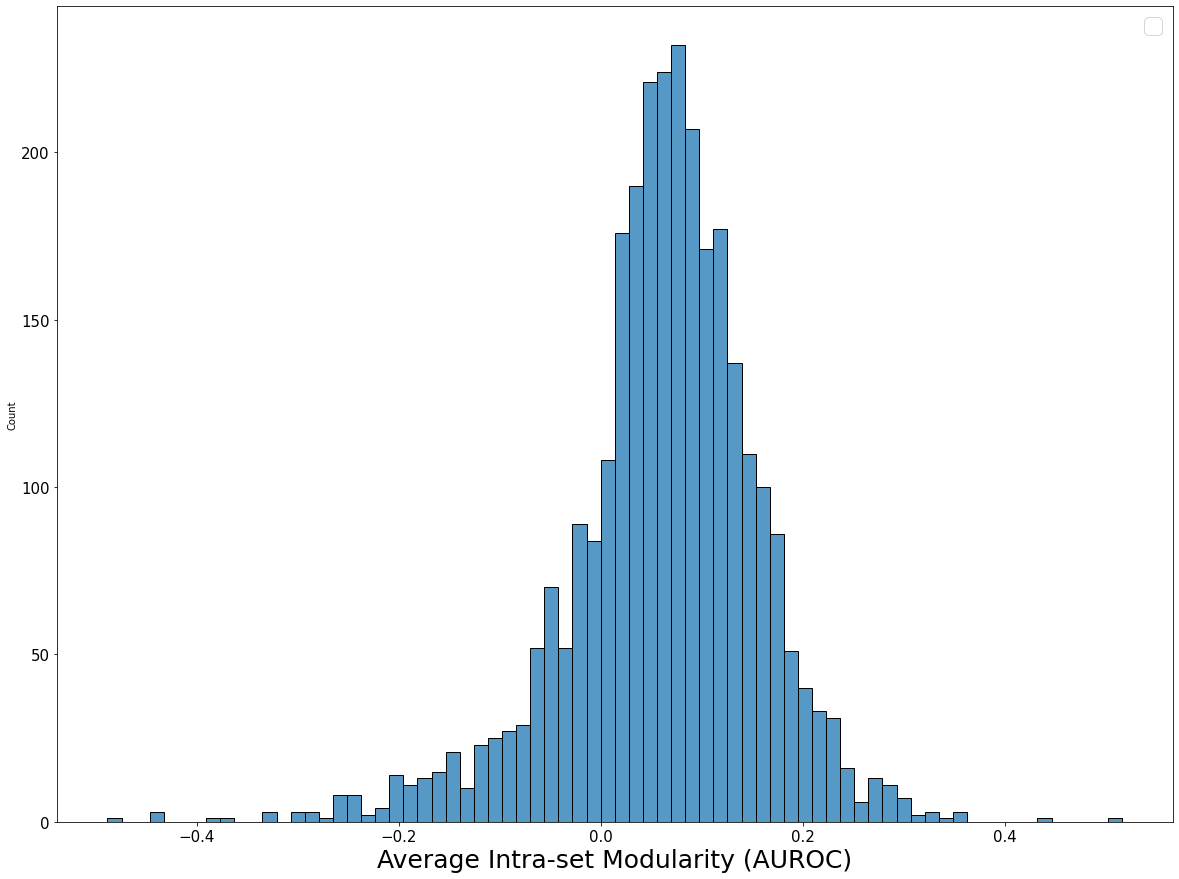

In [119]:
fig, ax = plt.subplots(figsize = (20,15))
sns.histplot(data = dataframe_for_finding_difference, x = 'Difference Between Meta and Single')
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)

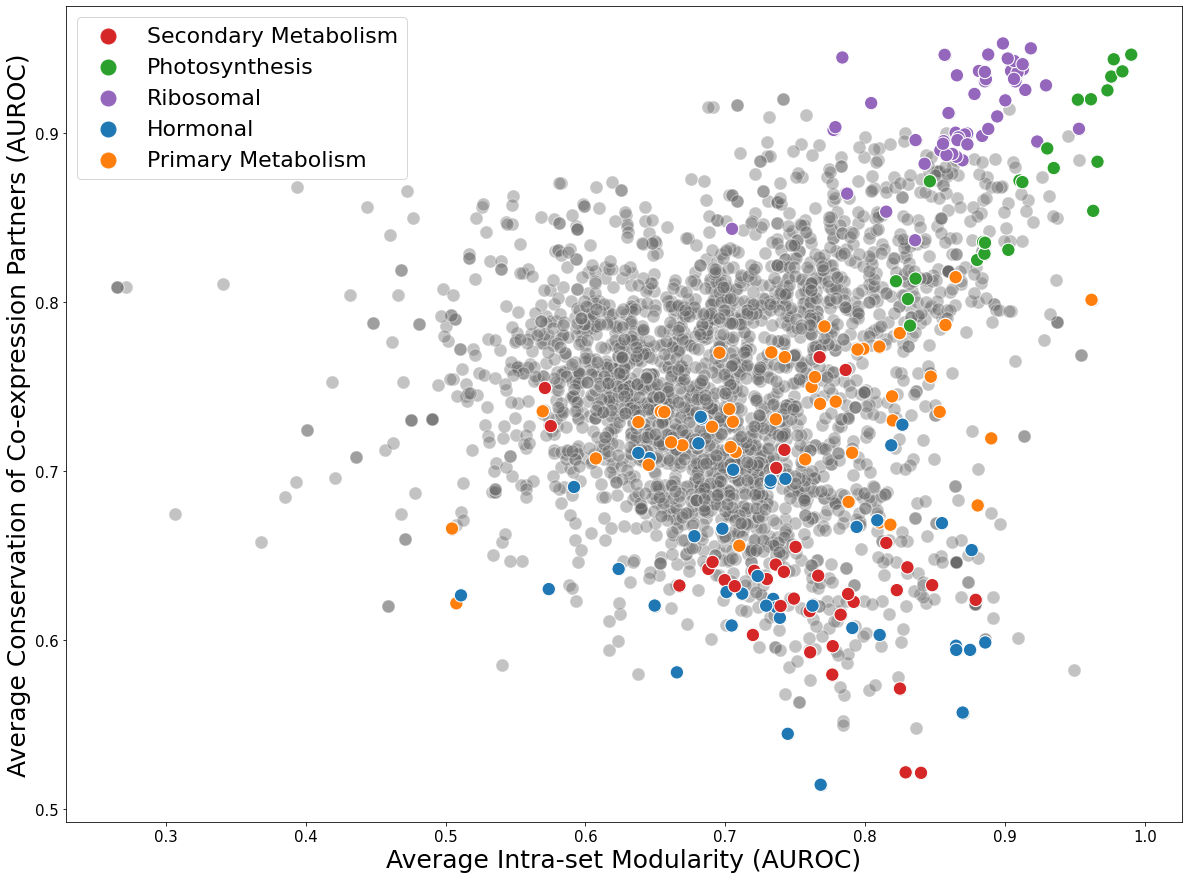

In [120]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_list,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal','Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

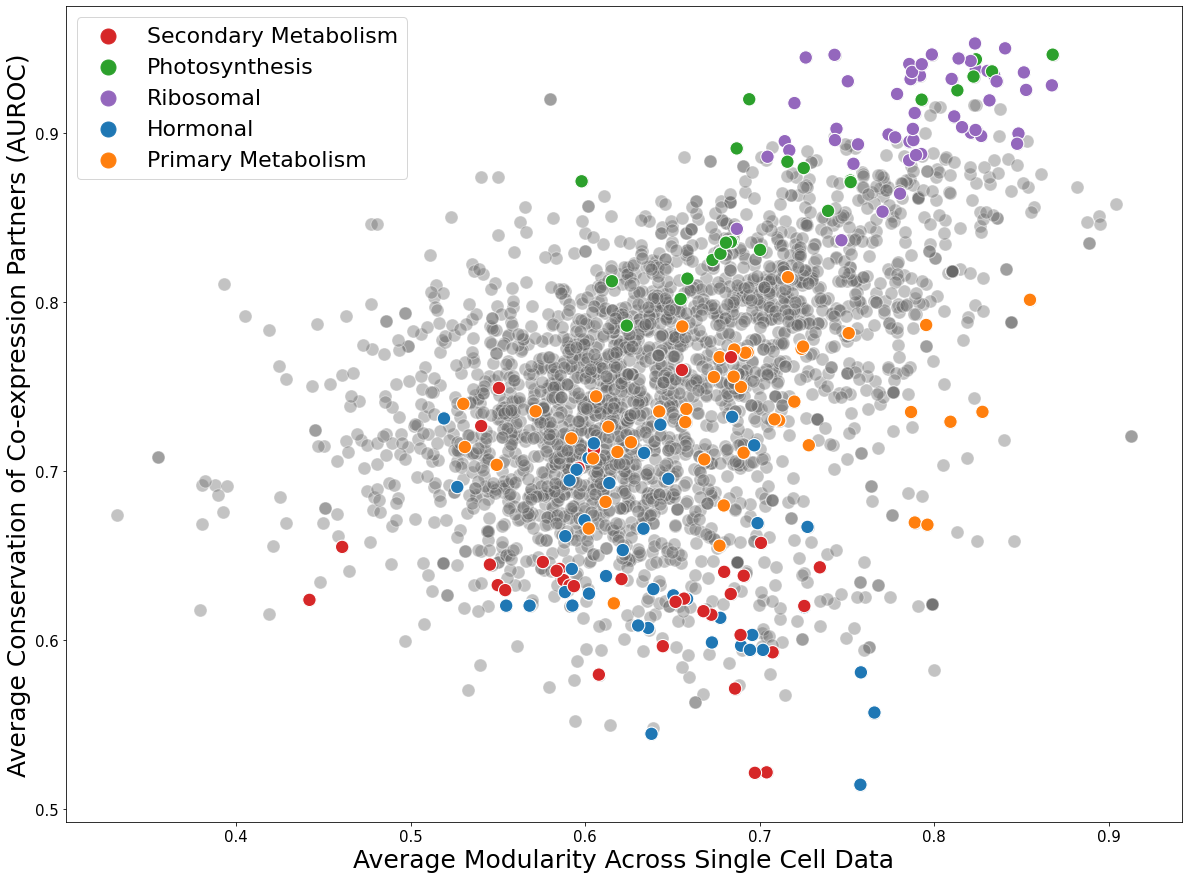

In [121]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_list,y = 'Avg FC',x = 'Single Cell Group',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Single Cell Group',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal','Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Modularity Across Single Cell Data", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [122]:
ident_line = np.linspace(0,2,num =200)

In [123]:
slimmed_to_original_list['Avg EGAD'].corr(slimmed_to_original_list['Single Cell Group'], method = 'spearman')

0.4545584927959359

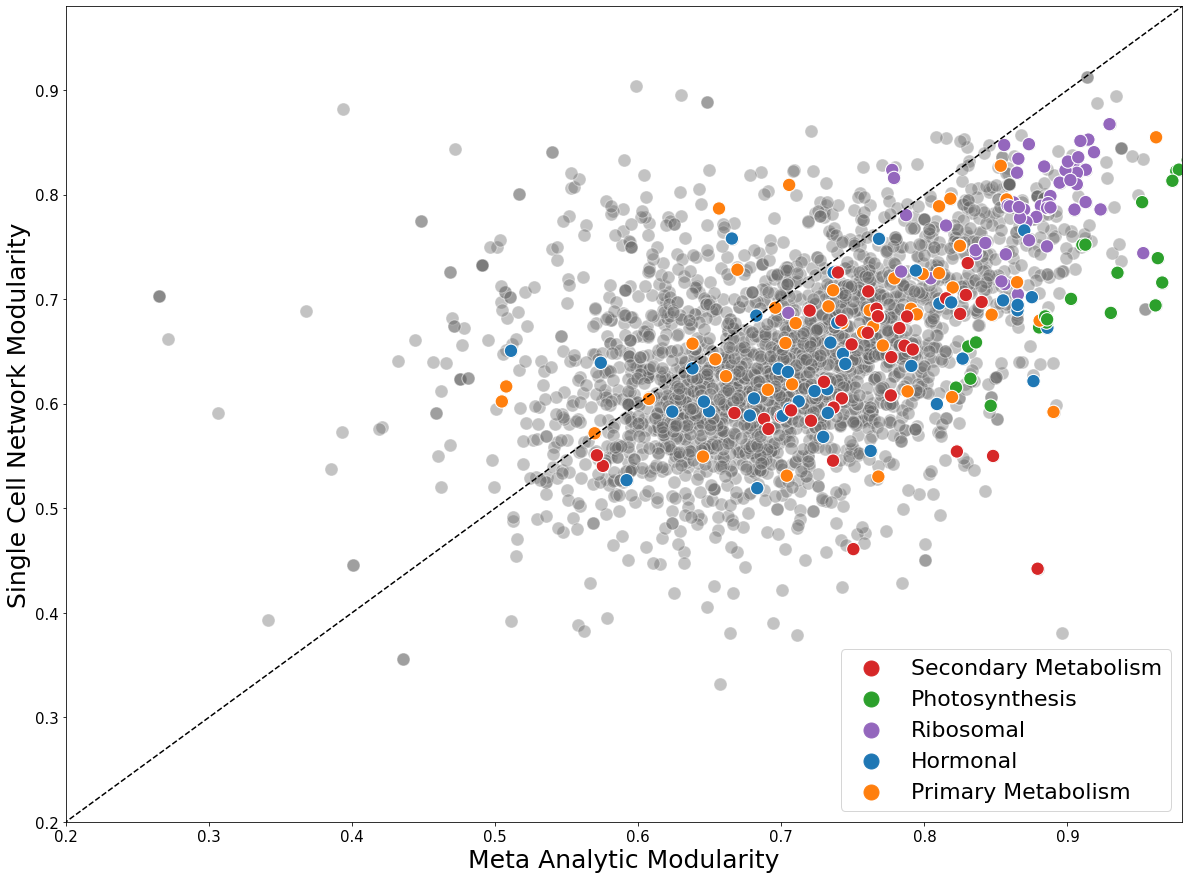

In [124]:
fig, ax = plt.subplots(figsize = (20,15))
fig.patch.set_facecolor('white')
sns.scatterplot(data = slimmed_to_original_list,y = 'Single Cell Group',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Avg EGAD',y = 'Single Cell Group',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal', 'Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)
plt.plot(ident_line,ident_line,'--k')
plt.xlim(.2,.98)
plt.ylim(.2,.98)
plt.ylabel("Single Cell Network Modularity", fontsize = 25)
plt.xlabel("Meta Analytic Modularity", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [125]:
genes_from_protoplast = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/binarized_protoplast_genes.csv', index_col= 0)

In [126]:
arab_genes_to_pandas = get_go_annotations_as_panda('arabidopsis')
arab_genes_to_pandas

GO_term     GO:0000002  GO:0000003  GO:0000009  GO:0000012  GO:0000014  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         1.0         0.0         0.0         0.0   
AT1G01040          0.0         1.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:0000015  GO:0000018  GO:0000019  GO:0000023  GO:0000024  ...  \
NetworkIDs                                                              ...   
AT1G01010          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01020          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01030          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01040          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01046          0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01360          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01370          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01400          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01410          0.0         0.0         0.0         0.0         0.0  ...   

GO_term     GO:2001251  GO:2001252  GO:2001253  GO:2001257  GO:2001279  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         0.0         0.0         0.0         0.0   
AT1G01040          0.0         0.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:2001280  GO:2001289  GO:2001293  GO:2001294  GO:2001295  
NetworkIDs                                                              
AT1G01010          0.0         0.0         0.0         0.0         0.0  
AT1G01020          0.0         0.0         0.0         0.0         0.0  
AT1G01030          0.0         0.0         0.0         0.0         0.0  
AT1G01040          0.0         0.0         0.0         0.0         0.0  
AT1G01046          0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
ATMG01350          0.0         0.0         0.0         0.0         0.0  
ATMG01360          0.0         0.0         0.0         0.0         0.0  
ATMG01370          0.0         0.0         0.0         0.0         0.0  
ATMG01400          0.0         0.0         0.0         0.0         0.0  
ATMG01410          0.0         0.0         0.0         0.0         0.0  

[28874 rows x 10704 columns]

In [127]:
# full_length_protoplast_genes = pd.DataFrame(index = arab_genes_to_pandas.index)
# full_length_protoplast_genes = full_length_protoplast_genes.merge(how = 'left',right = genes_from_protoplast,left_index= True, right_index= True)
# full_length_protoplast_genes = full_length_protoplast_genes.replace(np.nan, 0)
# full_length_protoplast_genes.to_csv('/data/passala/Generated_Tables/Reference_tables/binarized_protoplast_genes.csv')

In [128]:
genes_from_protoplast

Protoplast Gene
NetworkIDs                 
AT1G01010               1.0
AT1G01020               0.0
AT1G01030               0.0
AT1G01040               0.0
AT1G01046               0.0
...                     ...
ATMG01350               0.0
ATMG01360               0.0
ATMG01370               0.0
ATMG01400               0.0
ATMG01410               0.0

[28874 rows x 1 columns]

In [129]:
num_protoplast_genes_in_group = arab_genes_to_pandas.T.dot(genes_from_protoplast)
num_protoplast_genes_in_group


Protoplast Gene
GO_term                    
GO:0000002              0.0
GO:0000003             37.0
GO:0000009              0.0
GO:0000012              0.0
GO:0000014              1.0
...                     ...
GO:2001280              0.0
GO:2001289              0.0
GO:2001293              0.0
GO:2001294              0.0
GO:2001295              0.0

[10704 rows x 1 columns]

In [130]:
total_groupsize = arab_genes_to_pandas.sum()
percent_protoplast_gene = num_protoplast_genes_in_group['Protoplast Gene']/total_groupsize
num_protoplast_genes_in_group['Protoplast Gene'] = percent_protoplast_gene
num_protoplast_genes_in_group

Protoplast Gene
GO_term                    
GO:0000002         0.000000
GO:0000003         0.019004
GO:0000009         0.000000
GO:0000012         0.000000
GO:0000014         0.090909
...                     ...
GO:2001280         0.000000
GO:2001289         0.000000
GO:2001293         0.000000
GO:2001294         0.000000
GO:2001295         0.000000

[10704 rows x 1 columns]

In [131]:
num_protoplast_genes_in_group.sort_values(by = 'Protoplast Gene', ascending = False).head(20)

Protoplast Gene
GO_term                    
GO:0062046              1.0
GO:0015591              1.0
GO:0015690              1.0
GO:0010111              1.0
GO:0035264              1.0
GO:0004363              1.0
GO:0055090              1.0
GO:0019544              1.0
GO:0098755              1.0
GO:0009326              1.0
GO:0010055              1.0
GO:0015752              1.0
GO:0015753              1.0
GO:0080169              1.0
GO:0008473              1.0
GO:0018293              1.0
GO:0004168              1.0
GO:1902616              1.0
GO:0004159              1.0
GO:0015795              1.0

In [132]:
slimmed_to_original_with_protoplast = slimmed_to_original_list.merge(how = 'left', left_index= True, right_index = True, right = num_protoplast_genes_in_group)


In [133]:
slimmed_to_original_with_protoplast.sort_values(by = 'Protoplast Gene', ascending = False).head(20)

Avg FC  Avg EGAD  \
GO:0009065  0.617119  0.715161   
GO:2000022  0.731607  0.788053   
GO:0034440  0.687356  0.684113   
GO:0019395  0.708708  0.695992   
GO:0000815  0.774973  0.768448   
GO:0006635  0.712240  0.696670   
GO:0009062  0.708528  0.703296   
GO:0016624  0.714100  0.712898   
GO:0031407  0.632553  0.847979   
GO:0042435  0.636137  0.729786   
GO:0009695  0.653307  0.876218   
GO:0005779  0.744307  0.749233   
GO:0015217  0.641298  0.760842   
GO:1901681  0.645993  0.633719   
GO:0072329  0.704408  0.718629   
GO:0015866  0.641298  0.748886   
GO:0031231  0.744307  0.704226   
GO:0043295  0.557140  0.869796   
GO:1900750  0.557140  0.869796   
GO:0008540  0.870966  0.619138   

                                                         Name  \
GO:0009065      glutamine family amino acid catabolic process   
GO:2000022  regulation of jasmonic acid mediated signaling...   
GO:0034440                                    lipid oxidation   
GO:0019395                               fatty acid oxidation   
GO:0000815                                  ESCRT III complex   
GO:0006635                          fatty acid beta-oxidation   
GO:0009062                       fatty acid catabolic process   
GO:0016624  oxidoreductase activity, acting on the aldehyd...   
GO:0031407                         oxylipin metabolic process   
GO:0042435    indole-containing compound biosynthetic process   
GO:0009695                 jasmonic acid biosynthetic process   
GO:0005779         integral component of peroxisomal membrane   
GO:0015217             ADP transmembrane transporter activity   
GO:1901681                            sulfur compound binding   
GO:0072329              monocarboxylic acid catabolic process   
GO:0015866                                      ADP transport   
GO:0031231        intrinsic component of peroxisomal membrane   
GO:0043295                                glutathione binding   
GO:1900750                               oligopeptide binding   
GO:0008540    proteasome regulatory particle, base subcomplex   

            Single Cell Group            Annotation  Protoplast Gene  
GO:0009065           0.538508                  None         0.333333  
GO:2000022           0.650770                  None         0.261905  
GO:0034440           0.575324                  None         0.258621  
GO:0019395           0.603540                  None         0.250000  
GO:0000815           0.706911                  None         0.250000  
GO:0006635           0.601628                  None         0.250000  
GO:0009062           0.615662                  None         0.250000  
GO:0016624           0.498595                  None         0.230769  
GO:0031407           0.549966  Secondary Metabolism         0.230769  
GO:0042435           0.620866  Secondary Metabolism         0.226415  
GO:0009695           0.621574              Hormonal         0.222222  
GO:0005779           0.629729                  None         0.214286  
GO:0015217           0.576644                  None         0.214286  
GO:1901681           0.579341                  None         0.214286  
GO:0072329           0.617000                  None         0.214286  
GO:0015866           0.556946                  None         0.214286  
GO:0031231           0.658820                  None         0.214286  
GO:0043295           0.765699                  None         0.210526  
GO:1900750           0.765699              Hormonal         0.210526  
GO:0008540           0.770924                  None         0.210526

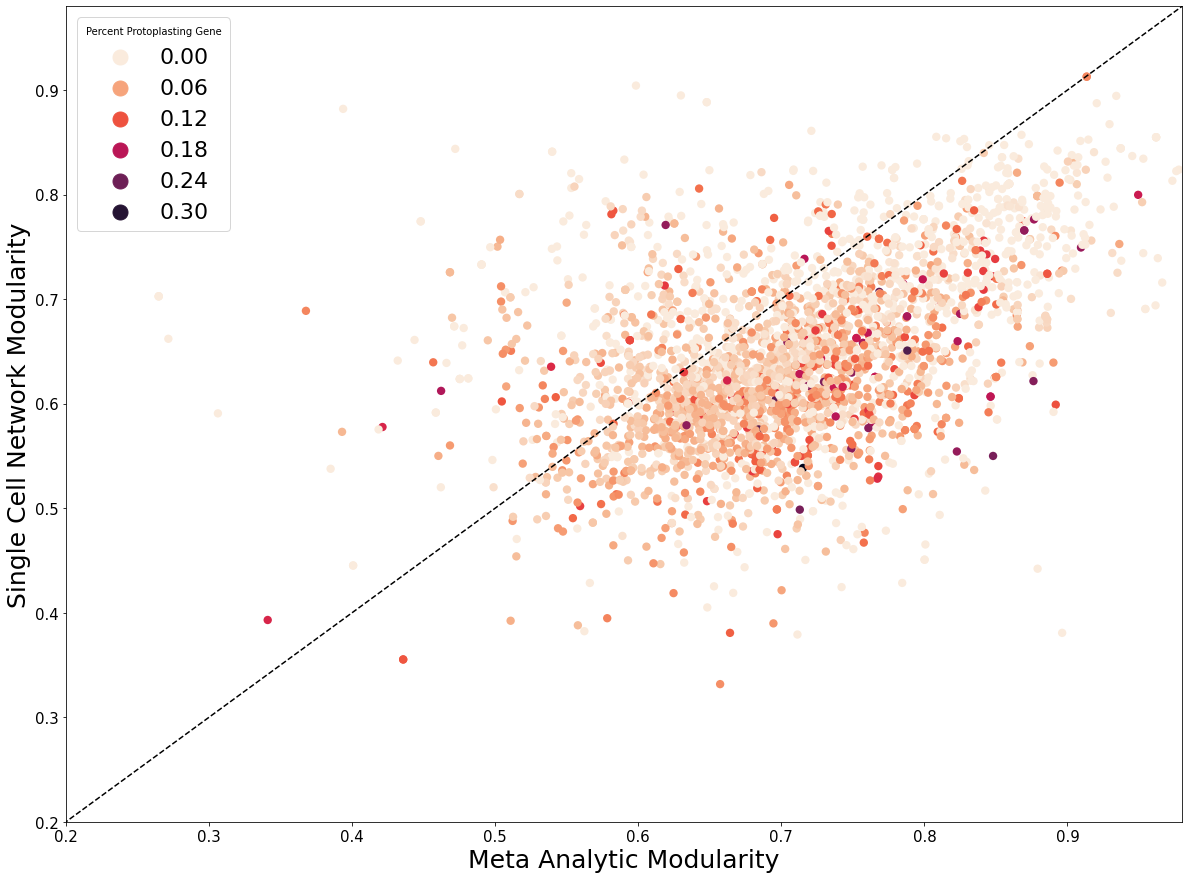

In [134]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_with_protoplast,y = 'Single Cell Group',x = 'Avg EGAD',s = 70, hue = 'Protoplast Gene', palette = 'rocket_r', linewidth = 0)
plt.plot(ident_line,ident_line,'--k')
plt.xlim(.2,.98)
plt.ylim(.2,.98)
plt.ylabel("Single Cell Network Modularity", fontsize = 25)
plt.xlabel("Meta Analytic Modularity", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5, title = 'Percent Protoplasting Gene')
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [135]:
slimmed_to_original_list

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051181  0.703080  0.595093                               NaN   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group Annotation  
GO:0000003           0.585704       None  
GO:0000018           0.773632       None  
GO:0000027           0.823763  Ribosomal  
GO:0000028           0.742855  Ribosomal  
GO:0000030           0.696564       None  
...                       ...        ...  
GO:0051181           0.536078       None  
GO:0051193           0.604822       None  
GO:0051184           0.575330       None  
GO:0051182           0.595758       None  
GO:0051185           0.589837       None  

[2931 rows x 5 columns]

In [136]:
list_of_titles = ['Columella','Trichoblasts','Xylem','Phloem 1','Cortex','QC/Stem Cells','Endodermis 1','Phloem 2','Endodermis 2']

In [137]:
list_of_columns = []
for number in np.arange(1,10):
    current_string = 'Single Cell Group ' + str(number)
    list_of_columns.append(current_string)
list_of_columns

['Single Cell Group 1',
 'Single Cell Group 2',
 'Single Cell Group 3',
 'Single Cell Group 4',
 'Single Cell Group 5',
 'Single Cell Group 6',
 'Single Cell Group 7',
 'Single Cell Group 8',
 'Single Cell Group 9']

In [138]:
color_list = ['tab:purple','tab:blue','tab:red','tab:green']


In [139]:
# # libraries & dataset
# import seaborn as sns
# import matplotlib.pyplot as plt
# # set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
# sns.set(style="darkgrid")
# df = sns.load_dataset('iris')

# my_pal = {species: "r" if species == "versicolor" else "b" for species in df.species.unique()}
# sns.boxplot( x=df["species"], y=df["sepal_length"], palette=my_pal)
# plt.show()

In [140]:
tester_pallete = {'Avg EGAD':'tab:gray','Single Cell Group 1':['tab:red','tab:green','tab:purple','tab:blue']}

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

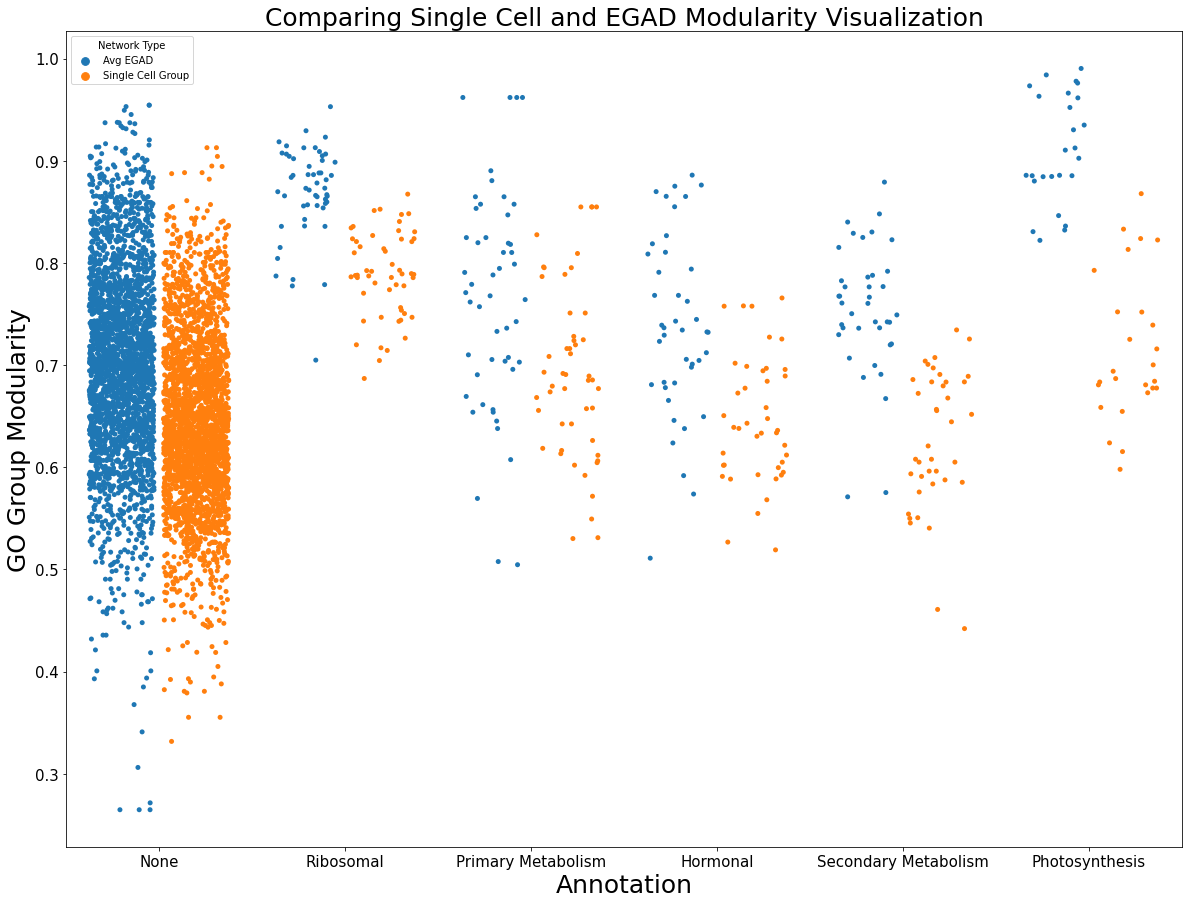

In [141]:
fig, ax = plt.subplots(figsize = (20,15))
tidy_test = pd.melt(slimmed_to_original_list, id_vars =['Name','Annotation'], value_vars = ['Avg EGAD','Single Cell Group'], ignore_index = False, var_name = 'Network Type', value_name = 'GO Group Modularity')
sns.stripplot(data = tidy_test, x = 'Annotation',y = 'GO Group Modularity',hue = 'Network Type',dodge = True, jitter = .35,)
plt.ylabel("GO Group Modularity", fontsize = 25)
plt.xlabel("Annotation", fontsize = 25)
plt.title("Comparing Single Cell and EGAD Modularity Visualization", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [142]:
slimmed_to_original_list

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051181  0.703080  0.595093                               NaN   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group Annotation  
GO:0000003           0.585704       None  
GO:0000018           0.773632       None  
GO:0000027           0.823763  Ribosomal  
GO:0000028           0.742855  Ribosomal  
GO:0000030           0.696564       None  
...                       ...        ...  
GO:0051181           0.536078       None  
GO:0051193           0.604822       None  
GO:0051184           0.575330       None  
GO:0051182           0.595758       None  
GO:0051185           0.589837       None  

[2931 rows x 5 columns]

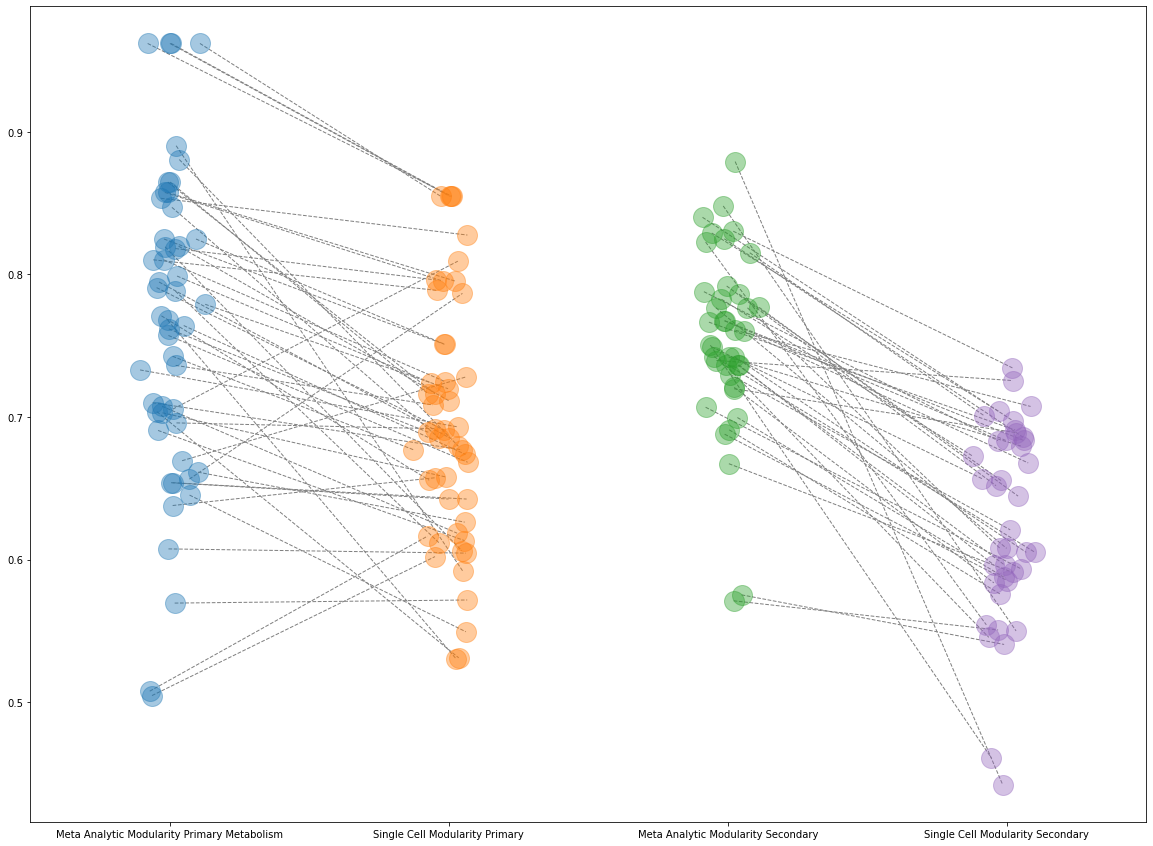

In [143]:
tester_slimmed_to_secondary = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']== 'Secondary Metabolism']
tester_slimmed_to_primary  = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']== 'Primary Metabolism']
tester_dataset_secondary = tester_slimmed_to_secondary[['Avg EGAD','Single Cell Group']]
tester_dataset_primary = tester_slimmed_to_primary[['Avg EGAD','Single Cell Group']]

tester_dataset_secondary = tester_dataset_secondary.reset_index(drop = True)
tester_dataset_primary = tester_dataset_primary.reset_index(drop = True)
tester_dataset = tester_dataset_primary.merge(right = tester_dataset_secondary, how = 'outer',right_index = True, left_index = True)
tester_dataset.columns = ['Meta Analytic Modularity Primary Metabolism', 'Single Cell Modularity Primary','Meta Analytic Modularity Secondary','Single Cell Modularity Secondary']
tester_dataset

jitter = .05
df_x_jitter = pd.DataFrame(np.random.normal(loc = 0, scale = jitter, size = tester_dataset.values.shape), columns = tester_dataset.columns)
df_x_jitter += np.arange(len(tester_dataset.columns))
df_x_jitter

fig, ax = plt.subplots(figsize = (20,15))
color_list = ['tab:blue','tab:orange','tab:green','tab:purple']

for (col,cur_color) in zip(tester_dataset,color_list):
    ax.plot(df_x_jitter[col],tester_dataset[col], 'o',alpha = .4, zorder = 1, ms = 20, mew = 1, color = cur_color)

ax.set_xticks (range(len(tester_dataset.columns)))
ax.set_xticklabels(tester_dataset.columns)
ax.set_xlim(-0.5,len(tester_dataset.columns)-0.5)

for idx in tester_dataset.index:
    ax.plot(df_x_jitter.loc[idx,['Meta Analytic Modularity Primary Metabolism','Single Cell Modularity Primary']],tester_dataset.loc[idx,['Meta Analytic Modularity Primary Metabolism','Single Cell Modularity Primary']], color = 'gray',linewidth = 1, linestyle = '--', zorder=-1)
    ax.plot(df_x_jitter.loc[idx,['Meta Analytic Modularity Secondary','Single Cell Modularity Secondary']],tester_dataset.loc[idx,['Meta Analytic Modularity Secondary','Single Cell Modularity Secondary']], color = 'gray',linewidth =1, linestyle = '--', zorder=-1)



In [144]:
slimmed_to_original_with_differnce_in_columns = slimmed_to_original_with_protoplast.copy()
slimmed_to_original_with_differnce_in_columns['Gain In Modularity in Single Cell'] = slimmed_to_original_with_differnce_in_columns['Single Cell Group'] - slimmed_to_original_with_differnce_in_columns['Avg EGAD']
slimmed_to_original_with_differnce_in_columns.sort_values(by = 'Gain In Modularity in Single Cell', ascending = False).head(20)

Avg FC  Avg EGAD  \
GO:0030131  0.868312  0.393721   
GO:0002790  0.809298  0.264824   
GO:0035592  0.809298  0.264824   
GO:0071692  0.809298  0.264824   
GO:0009306  0.809298  0.271568   
GO:0030119  0.865858  0.472096   
GO:0003400  0.787529  0.447933   
GO:0090113  0.787529  0.447933   
GO:0016408  0.658338  0.367729   
GO:0033176  0.858111  0.598389   
GO:0030126  0.819468  0.539812   
GO:0030663  0.819468  0.539812   
GO:0010496  0.674616  0.306213   
GO:0030117  0.826072  0.516922   
GO:0048475  0.826072  0.516922   
GO:0030137  0.817373  0.553158   
GO:0033179  0.846308  0.629796   
GO:0006904  0.819257  0.468391   
GO:0140029  0.819257  0.468391   
GO:0030127  0.819955  0.558632   

                                                         Name  \
GO:0030131                           clathrin adaptor complex   
GO:0002790                                  peptide secretion   
GO:0035592  establishment of protein localization to extra...   
GO:0071692       protein localization to extracellular region   
GO:0009306                                  protein secretion   
GO:0030119              AP-type membrane coat adaptor complex   
GO:0003400                regulation of COPII vesicle coating   
GO:0090113  regulation of ER to Golgi vesicle-mediated tra...   
GO:0016408                         C-acyltransferase activity   
GO:0033176          proton-transporting V-type ATPase complex   
GO:0030126                                  COPI vesicle coat   
GO:0030663                       COPI-coated vesicle membrane   
GO:0010496                            intercellular transport   
GO:0030117                                      membrane coat   
GO:0048475                                    coated membrane   
GO:0030137                                COPI-coated vesicle   
GO:0033179       proton-transporting V-type ATPase, V0 domain   
GO:0006904             vesicle docking involved in exocytosis   
GO:0140029                                   exocytic process   
GO:0030127                                 COPII vesicle coat   

            Single Cell Group Annotation  Protoplast Gene  \
GO:0030131           0.881986       None         0.000000   
GO:0002790           0.702663       None         0.000000   
GO:0035592           0.702663       None         0.000000   
GO:0071692           0.702663       None         0.000000   
GO:0009306           0.662037       None         0.000000   
GO:0030119           0.843721       None         0.000000   
GO:0003400           0.774336       None         0.000000   
GO:0090113           0.774336       None         0.000000   
GO:0016408           0.688780       None         0.083333   
GO:0033176           0.904259       None         0.000000   
GO:0030126           0.841036       None         0.000000   
GO:0030663           0.841036       None         0.000000   
GO:0010496           0.590708       None         0.000000   
GO:0030117           0.800540       None         0.014085   
GO:0048475           0.800540       None         0.014085   
GO:0030137           0.820453       None         0.000000   
GO:0033179           0.894827       None         0.000000   
GO:0006904           0.725686       None         0.041667   
GO:0140029           0.725686       None         0.041667   
GO:0030127           0.814824       None         0.000000   

            Gain In Modularity in Single Cell  
GO:0030131                           0.488265  
GO:0002790                           0.437838  
GO:0035592                           0.437838  
GO:0071692                           0.437838  
GO:0009306                           0.390469  
GO:0030119                           0.371625  
GO:0003400                           0.326403  
GO:0090113                           0.326403  
GO:0016408                           0.321051  
GO:0033176                           0.305870  
GO:0030126                           0.301224  
GO:0030663                           0.301224  
GO:0010496                 

In [145]:
clathrin_genes = arab_genes_to_pandas.loc[arab_genes_to_pandas['GO:0030131'] == 1].index.to_list()

In [146]:
clathrin_genes

['AT1G10730',
 'AT1G23900',
 'AT1G56590',
 'AT1G60070',
 'AT1G60780',
 'AT2G20790',
 'AT4G11380',
 'AT4G23460',
 'AT4G24550',
 'AT5G11490',
 'AT5G22770',
 'AT5G22780',
 'AT5G46630']

In [147]:
single_cell_expression_levels_per_cell_type = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/avg_expression_per_gene_all_tissue_types.csv',index_col= 0)
single_cell_expression_levels_per_cell_type

Dataset 1 Tissue Type 1  Dataset 2 Tissue Type 1  \
AT1G01010                 0.121605                 0.523011   
AT1G01020                 0.366243                 0.929447   
AT1G01030                 0.031003                 0.252739   
AT1G01040                 0.090848                 0.215309   
AT1G01050                 3.273052                 3.072888   
...                            ...                      ...   
ATCG01110                 0.000000                 0.003474   
ATCG01120                 0.005455                 0.011101   
ATCG01130                 1.070228                 1.122886   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.000000   

           Dataset 3 Tissue Type 1  Dataset 4 Tissue Type 1  \
AT1G01010                 0.595947                 0.129706   
AT1G01020                 2.021641                 0.243215   
AT1G01030                 0.225411                 0.007583   
AT1G01040                 0.259004                 0.107929   
AT1G01050                 5.361505                 0.947332   
...                            ...                      ...   
ATCG01110                 0.012186                 0.108181   
ATCG01120                 0.026325                 0.162838   
ATCG01130                 2.159980                 1.014451   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.003550   

           Dataset 1 Tissue Type 2  Dataset 2 Tissue Type 2  \
AT1G01010                 0.585265                 0.304047   
AT1G01020                 0.725181                 1.691138   
AT1G01030                 0.000000                 0.166507   
AT1G01040                 0.130403                 0.320185   
AT1G01050                 3.577862                 4.785543   
...                            ...                      ...   
ATCG01110                 0.005697                 0.008769   
ATCG01120                 0.057938                 0.035758   
ATCG01130                 2.460740                 2.929678   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.000000   

           Dataset 3 Tissue Type 2  Dataset 4 Tissue Type 2  \
AT1G01010                 1.103968                 2.193456   
AT1G01020                 2.851870                 0.706450   
AT1G01030                 0.022735                 0.021803   
AT1G01040                 0.216974                 0.197384   
AT1G01050                 4.398198                 1.371240   
...                            ...                      ...   
ATCG01110                 0.005439                 0.169166   
ATCG01120                 0.017484                 0.264577   
ATCG01130                 1.805271                 2.724424   
ATCG01230                 0.000000                 0.001495   
ATCG01310                 0.000000                 0.007055   

           Dataset 1 Tissue Type 3  Dataset 2 Tissue Type 3  ...  \
AT1G01010                 0.548165                 0.146582  ...   
AT1G01020                 0.222234                 1.581122  ...   
AT1G01030                 0.000000                 0.000000  ...   
AT1G01040                 0.467154                 0.642848  ...   
AT1G01050                 4.070703                 4.862555  ...   
...                            ...                      ...  ...   
ATCG01110                 0.000000                 0.000000  ...   
ATCG01120                 0.000000                 0.052588  ...   
ATCG01130                 3.215276                 1.833990  ...   
ATCG01230                 0.000000                 0.000000  ...   
ATCG01310                 0.000000                 0.000000  ...   

           Dataset 4 Tissue Type 5  Dataset 2 Tissue Type 6  \
AT1G01010                 2.133073                 0.365322   
AT1G01020                 0.408642      

In [148]:
clathrin_gene_expression_levels = single_cell_expression_levels_per_cell_type.loc[clathrin_genes]
clathrin_gene_expression_levels.mean()

Dataset 1 Tissue Type 1    1.364263
Dataset 2 Tissue Type 1    1.065023
Dataset 3 Tissue Type 1    1.677623
Dataset 4 Tissue Type 1    0.364328
Dataset 1 Tissue Type 2    2.722607
Dataset 2 Tissue Type 2    2.651992
Dataset 3 Tissue Type 2    2.405537
Dataset 4 Tissue Type 2    1.364981
Dataset 1 Tissue Type 3    1.887376
Dataset 2 Tissue Type 3    2.353604
Dataset 3 Tissue Type 3    2.024307
Dataset 4 Tissue Type 3    1.008175
Dataset 1 Tissue Type 4    1.422305
Dataset 2 Tissue Type 4    1.424770
Dataset 3 Tissue Type 4    1.794860
Dataset 4 Tissue Type 4    0.730265
Dataset 1 Tissue Type 5    2.051652
Dataset 2 Tissue Type 5    2.027220
Dataset 3 Tissue Type 5    1.690120
Dataset 4 Tissue Type 5    0.669448
Dataset 2 Tissue Type 6    1.535673
Dataset 4 Tissue Type 6    0.865037
Dataset 1 Tissue Type 7    1.541158
Dataset 3 Tissue Type 7    1.761703
Dataset 4 Tissue Type 7    0.735239
Dataset 1 Tissue Type 8    1.659894
Dataset 4 Tissue Type 8    0.646260
Dataset 1 Tissue Type 9    2

In [149]:
module_expression_df = pd.DataFrame(columns =['Clathrin Module Expression','Tissue Type'])
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = clathrin_gene_expression_levels.filter(like = current_type)
    mean_module_expression = df_with_this_type.mean()
    for index, values in mean_module_expression.iteritems():
        list_to_append = [[values,current_type]]
        df_to_append  = pd.DataFrame(columns = ['Clathrin Module Expression','Tissue Type'], data = list_to_append)
        module_expression_df = module_expression_df.append(df_to_append, ignore_index= True)



In [150]:
df_with_this_type

Dataset 1 Tissue Type 9  Dataset 2 Tissue Type 9
AT1G10730                 0.000000                 0.404094
AT1G23900                 1.014316                 1.755980
AT1G56590                 0.729622                 1.713169
AT1G60070                 2.582701                 2.908260
AT1G60780                 5.033238                 4.361403
AT2G20790                 1.023444                 1.007272
AT4G11380                 3.954995                 1.839521
AT4G23460                 1.602184                 2.028946
AT4G24550                 2.313078                 2.658283
AT5G11490                 2.220871                 2.227834
AT5G22770                 1.996827                 1.452249
AT5G22780                 2.238089                 2.325156
AT5G46630                 4.257159                 4.003362

In [151]:
plotting_clatherin_genes = clathrin_gene_expression_levels.melt(ignore_index = False, value_vars = clathrin_gene_expression_levels.columns)


In [152]:
plotting_clatherin_genes = plotting_clatherin_genes.reset_index()
plotting_clatherin_genes = plotting_clatherin_genes.rename(columns = {'index':'Gene', 'value':'Normalized Expression'})
plotting_clatherin_genes['Tissue Type'] = np.nan
plotting_clatherin_genes

Gene                 variable  Normalized Expression  Tissue Type
0    AT1G10730  Dataset 1 Tissue Type 1               0.029122          NaN
1    AT1G23900  Dataset 1 Tissue Type 1               0.874305          NaN
2    AT1G56590  Dataset 1 Tissue Type 1               0.662339          NaN
3    AT1G60070  Dataset 1 Tissue Type 1               1.455672          NaN
4    AT1G60780  Dataset 1 Tissue Type 1               2.729164          NaN
..         ...                      ...                    ...          ...
372  AT4G24550  Dataset 2 Tissue Type 9               2.658283          NaN
373  AT5G11490  Dataset 2 Tissue Type 9               2.227834          NaN
374  AT5G22770  Dataset 2 Tissue Type 9               1.452249          NaN
375  AT5G22780  Dataset 2 Tissue Type 9               2.325156          NaN
376  AT5G46630  Dataset 2 Tissue Type 9               4.003362          NaN

[377 rows x 4 columns]

In [153]:
for cur_type in np.arange(1,10):
    str_cur_type = f"Type {cur_type}"
    plotting_clatherin_genes['Tissue Type'].loc[plotting_clatherin_genes['variable'].str.contains(str_cur_type)] = str_cur_type
plotting_clatherin_genes

    

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Gene                 variable  Normalized Expression Tissue Type
0    AT1G10730  Dataset 1 Tissue Type 1               0.029122      Type 1
1    AT1G23900  Dataset 1 Tissue Type 1               0.874305      Type 1
2    AT1G56590  Dataset 1 Tissue Type 1               0.662339      Type 1
3    AT1G60070  Dataset 1 Tissue Type 1               1.455672      Type 1
4    AT1G60780  Dataset 1 Tissue Type 1               2.729164      Type 1
..         ...                      ...                    ...         ...
372  AT4G24550  Dataset 2 Tissue Type 9               2.658283      Type 9
373  AT5G11490  Dataset 2 Tissue Type 9               2.227834      Type 9
374  AT5G22770  Dataset 2 Tissue Type 9               1.452249      Type 9
375  AT5G22780  Dataset 2 Tissue Type 9               2.325156      Type 9
376  AT5G46630  Dataset 2 Tissue Type 9               4.003362      Type 9

[377 rows x 4 columns]

In [154]:
module_expression_df

Clathrin Module Expression Tissue Type
0                     1.364263      Type 1
1                     1.065023      Type 1
2                     1.677623      Type 1
3                     0.364328      Type 1
4                     2.722607      Type 2
5                     2.651992      Type 2
6                     2.405537      Type 2
7                     1.364981      Type 2
8                     1.887376      Type 3
9                     2.353604      Type 3
10                    2.024307      Type 3
11                    1.008175      Type 3
12                    1.422305      Type 4
13                    1.424770      Type 4
14                    1.794860      Type 4
15                    0.730265      Type 4
16                    2.051652      Type 5
17                    2.027220      Type 5
18                    1.690120      Type 5
19                    0.669448      Type 5
20                    1.535673      Type 6
21                    0.865037      Type 6
22                    1.541158      Type 7
23                    1.761703      Type 7
24                    0.735239      Type 7
25                    1.659894      Type 8
26                    0.646260      Type 8
27                    2.228194      Type 9
28                    2.206579      Type 9

In [155]:
meta_cluster_labels_from_1_to_9 = ['Columella','Trichoblasts','Xylem','Phloem 1','Cortex','Meristem','Endodermis','Phloem 2','Endodermis 2']

[Text(0, 0, 'Columella'),
 Text(1, 0, 'Trichoblasts'),
 Text(2, 0, 'Xylem'),
 Text(3, 0, 'Phloem 1'),
 Text(4, 0, 'Cortex'),
 Text(5, 0, 'Meristem'),
 Text(6, 0, 'Endodermis'),
 Text(7, 0, 'Phloem 2'),
 Text(8, 0, 'Endodermis 2')]

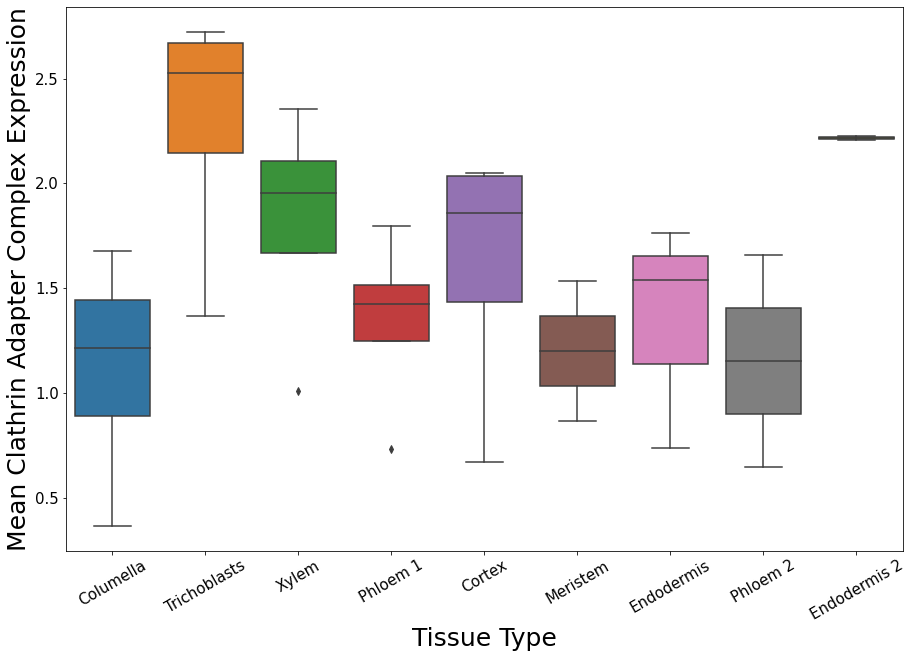

In [156]:

fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = module_expression_df, x = 'Tissue Type', y = 'Clathrin Module Expression' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Mean Clathrin Adapter Complex Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15, rotation = 30)
plt.yticks(fontsize = 15)
ax.set_xticklabels(labels = meta_cluster_labels_from_1_to_9)

#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


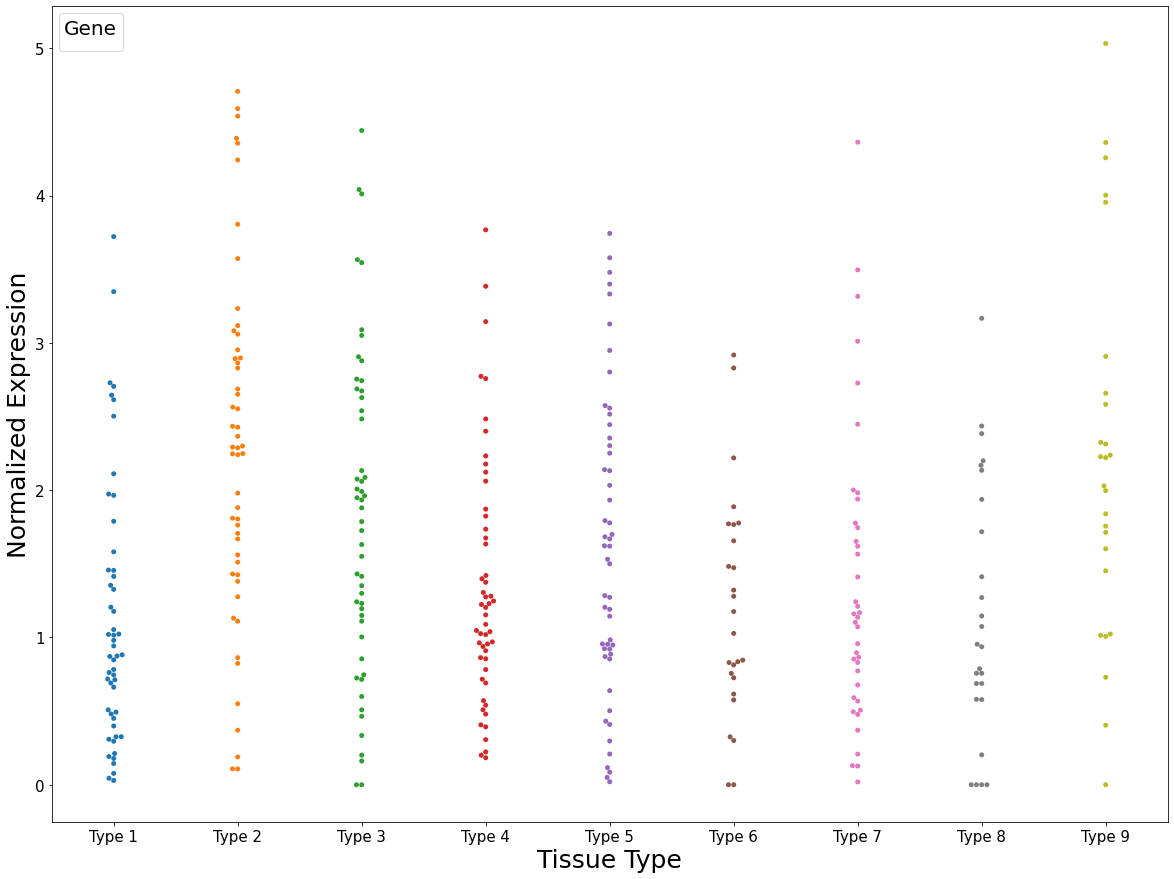

In [157]:

fig, ax = plt.subplots(figsize = (20,15))
sns.swarmplot(data = plotting_clatherin_genes, x = 'Tissue Type',y = 'Normalized Expression')
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Normalized Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [260]:
def plot_go_group_mean_expression(GO_group):
    genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas[GO_group] == 1].index.to_list()
    genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
    expression_levels = single_cell_expression_levels_per_cell_type.loc[genes_of_interest]
    expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])
    for tissue_type in np.arange(1,10):
        current_type = f"Type {tissue_type}"
        df_with_this_type = expression_levels.filter(like = current_type)
        mean_module_expression = df_with_this_type.mean()
        for index, values in mean_module_expression.iteritems():
            list_to_append = [[values,current_type]]
            df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)
            expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)
    fig, ax = plt.subplots(figsize = (15,10))
    sns.boxplot(data = expression_of_genes_of_interest_df, x = 'Tissue Type', y = 'Module Expression' )
    fig.patch.set_facecolor('white')
    # plt.xlim(.2,.98)
    # plt.ylim(.2,.98)
    plt.ylabel("Mean Module Expression", fontsize = 25)
    plt.xlabel("Tissue Type", fontsize = 25)
    #plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
    plt.xticks(fontsize = 15, rotation = 30)
    plt.yticks(fontsize = 15)
    ax.set_xticklabels(labels = meta_cluster_labels_from_1_to_9)
    #plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
    #plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)


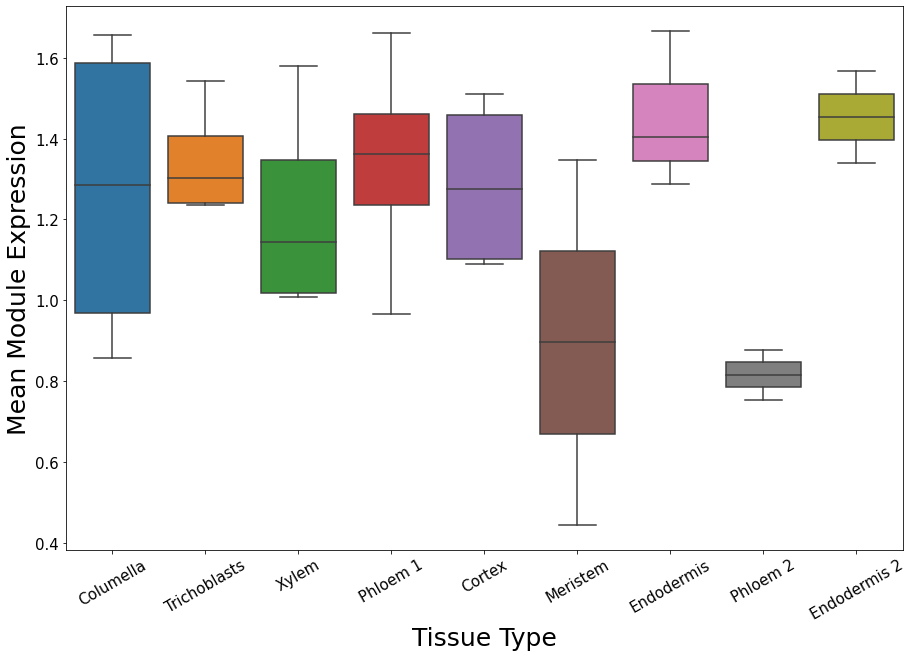

In [261]:
plot_go_group_mean_expression('GO:0031407') ## Secondary Metabolism Group that Lost a lot of modularity

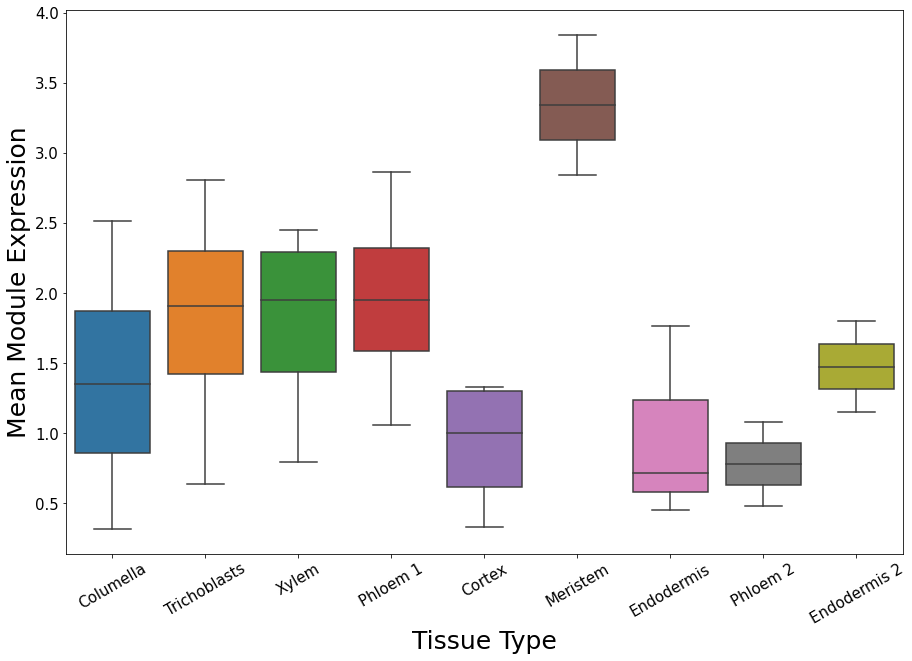

In [262]:
plot_go_group_mean_expression('GO:0033290') ## Ribosomal that was high in both

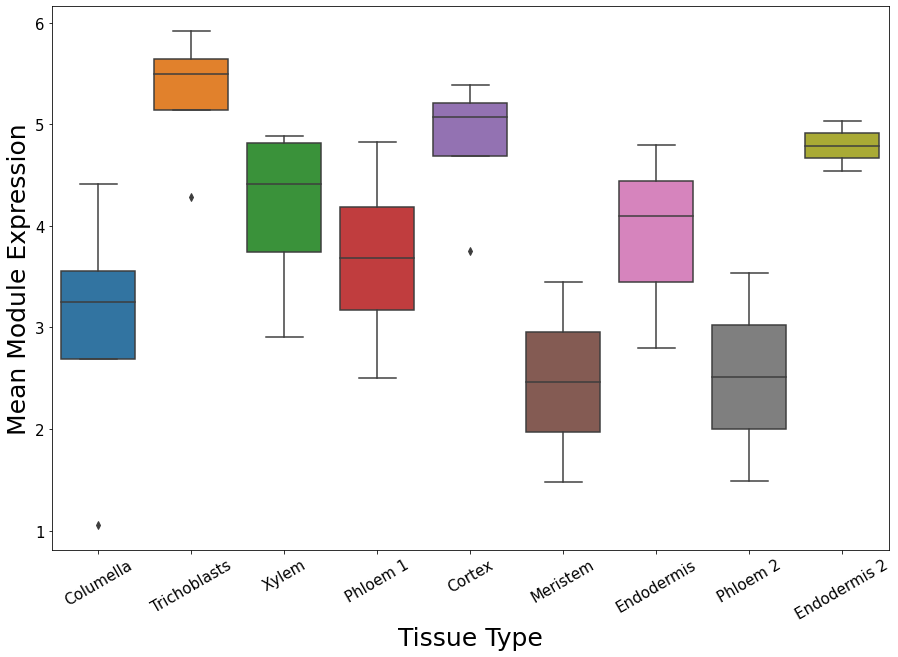

In [263]:
plot_go_group_mean_expression('GO:0033176') ## Proton Group That Gained A lot of Modularity

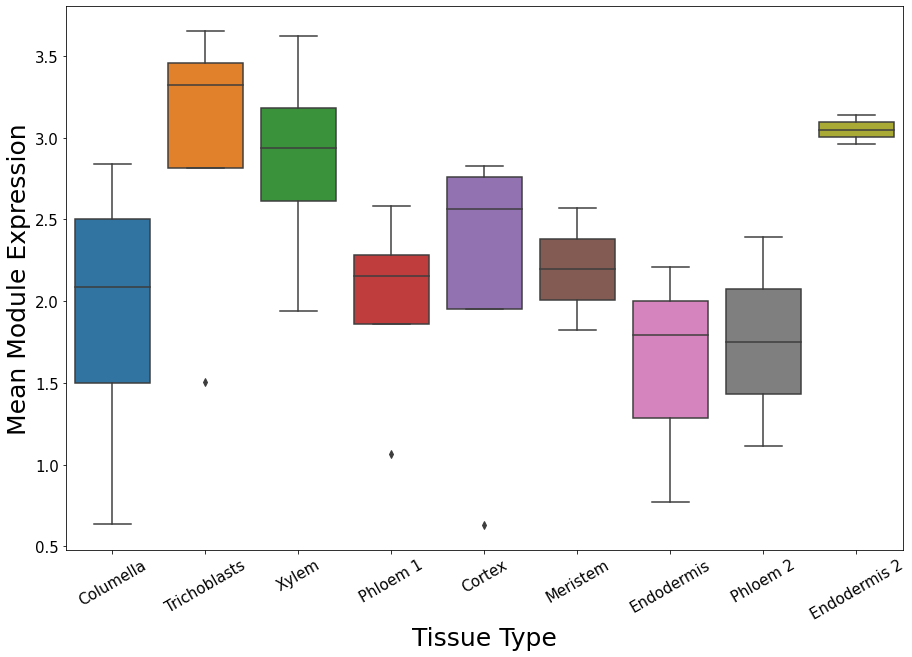

In [264]:
plot_go_group_mean_expression('GO:0030126') ## Different Export Group - Copi vesicle coat

In [265]:
copi_genes = arab_genes_to_pandas.loc[arab_genes_to_pandas['GO:0030126'] == 1].index.to_list()
list(set(clathrin_genes).intersection(set(copi_genes)))

[]

In [266]:
len(arab_genes_to_pandas.loc[arab_genes_to_pandas['GO:0033558'] == 1].index.to_list())

44

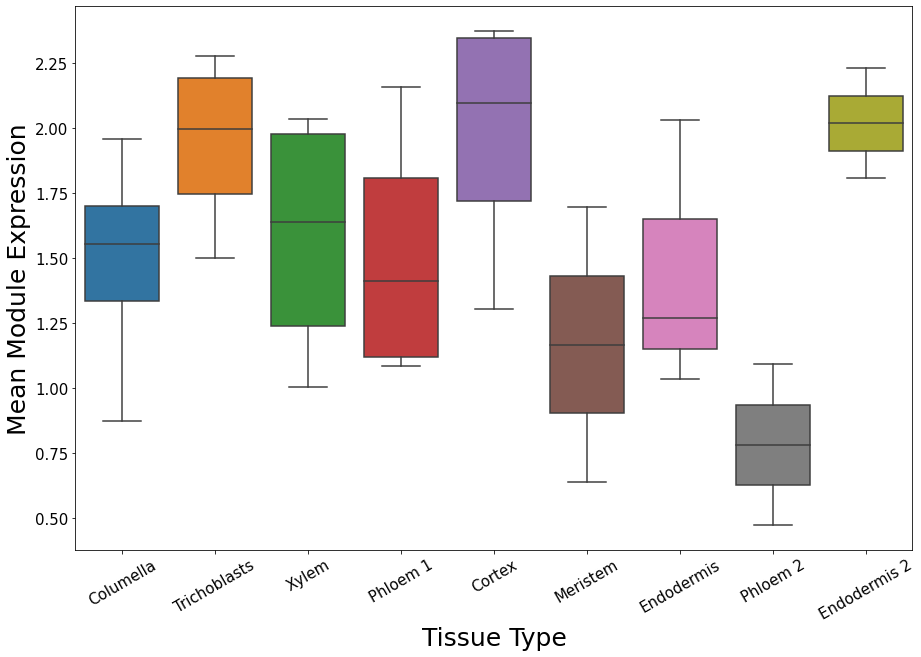

In [268]:
plot_go_group_mean_expression('GO:0016408')## Protein Deacetalyse activity


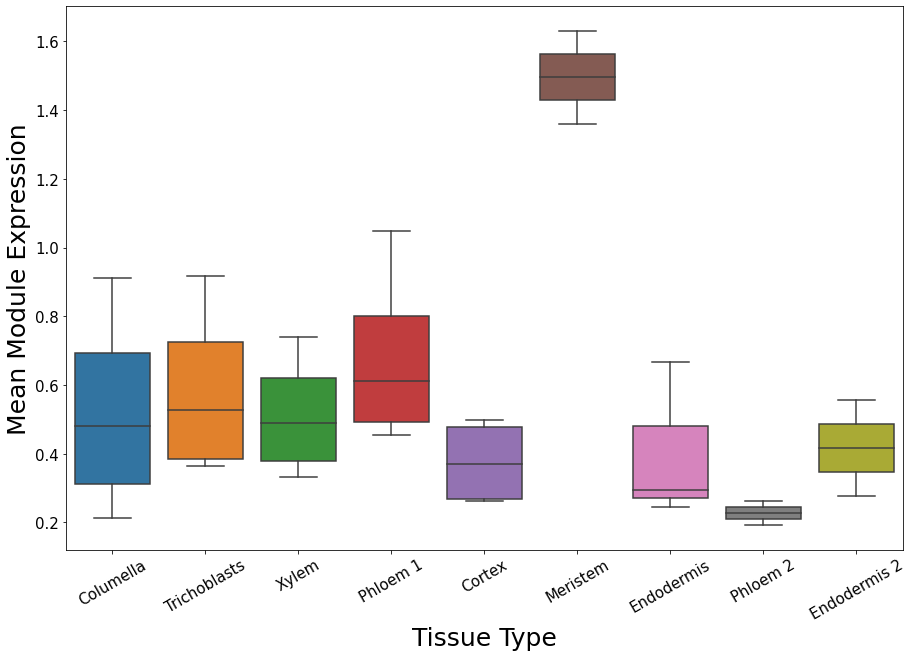

In [267]:
plot_go_group_mean_expression('GO:0033558')## Protein Deacetalyse activity
#

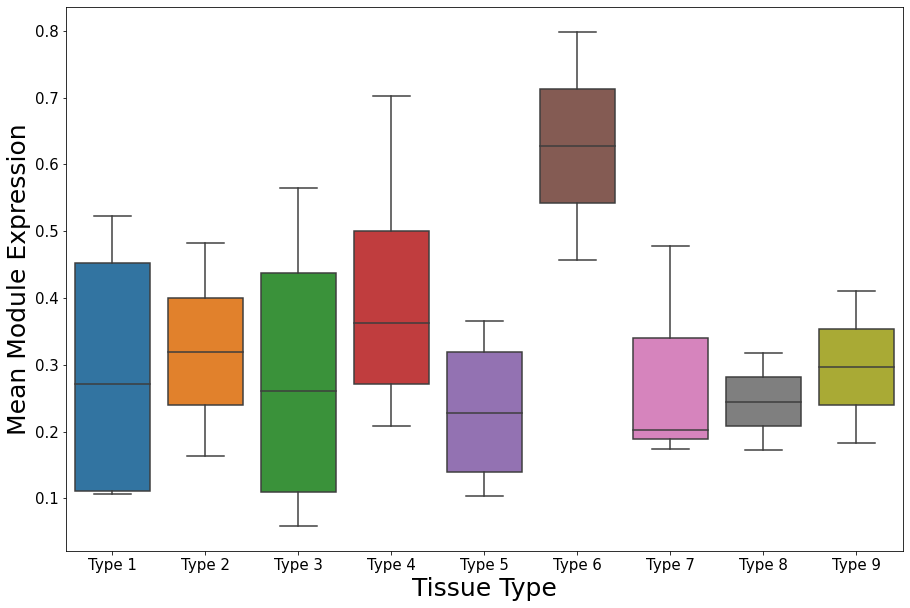

In [166]:
plot_go_group_mean_expression('GO:0032296')##double-stranded RNA-specific ribonuclease acti...	

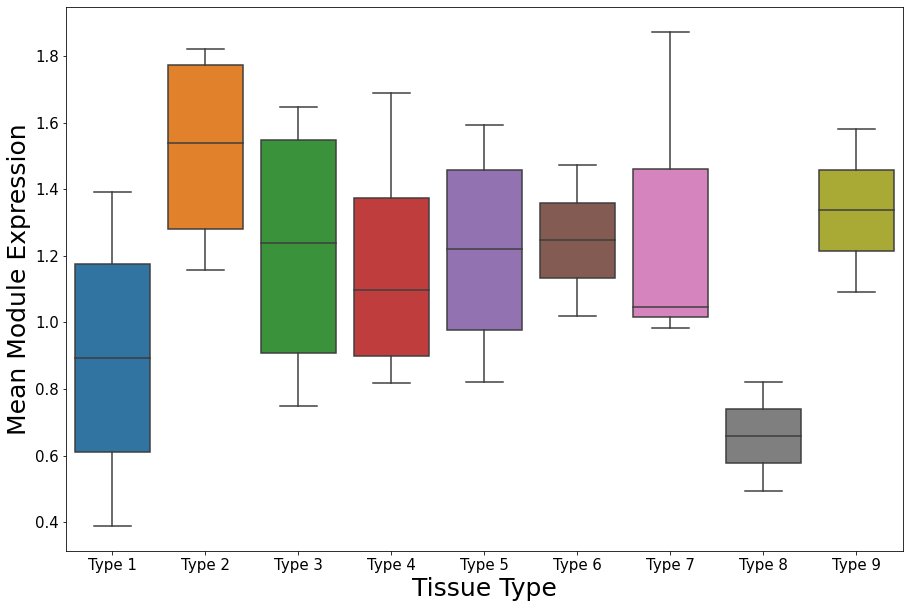

In [167]:
plot_go_group_mean_expression('GO:0018107') ###peptidyl-threonine phosphorylation

In [168]:
slimmed_to_original_with_differnce_in_columns.sort_values(by = 'Gain In Modularity in Single Cell', ascending = False).head(50)

Avg FC  Avg EGAD  \
GO:0030131  0.868312  0.393721   
GO:0002790  0.809298  0.264824   
GO:0035592  0.809298  0.264824   
GO:0071692  0.809298  0.264824   
GO:0009306  0.809298  0.271568   
GO:0030119  0.865858  0.472096   
GO:0003400  0.787529  0.447933   
GO:0090113  0.787529  0.447933   
GO:0016408  0.658338  0.367729   
GO:0033176  0.858111  0.598389   
GO:0030126  0.819468  0.539812   
GO:0030663  0.819468  0.539812   
GO:0010496  0.674616  0.306213   
GO:0030117  0.826072  0.516922   
GO:0048475  0.826072  0.516922   
GO:0030137  0.817373  0.553158   
GO:0033179  0.846308  0.629796   
GO:0006904  0.819257  0.468391   
GO:0140029  0.819257  0.468391   
GO:0030127  0.819955  0.558632   
GO:1902652  0.754702  0.503431   
GO:0060627  0.791918  0.496524   
GO:0007030  0.834487  0.553189   
GO:0030120  0.817014  0.555410   
GO:0000159  0.777042  0.501604   
GO:0033178  0.851911  0.590262   
GO:0031545  0.731031  0.490460   
GO:0019798  0.731031  0.490460   
GO:0004656  0.731031  0.490460   
GO:0018401  0.731031  0.490460   
GO:0046961  0.835218  0.647866   
GO:0044769  0.835218  0.647866   
GO:0016482  0.793969  0.551895   
GO:0110156  0.857688  0.547626   
GO:0033962  0.856276  0.443632   
GO:0006891  0.799037  0.577201   
GO:0012507  0.791336  0.603703   
GO:0035304  0.752888  0.469843   
GO:0033558  0.804359  0.431896   
GO:0006893  0.824358  0.539621   
GO:0032296  0.792285  0.504111   
GO:0030660  0.802730  0.580726   
GO:0042147  0.793443  0.563634   
GO:0048209  0.797955  0.543212   
GO:0008417  0.659825  0.471357   
GO:0036065  0.659825  0.471357   
GO:0005838  0.870384  0.582565   
GO:0022624  0.870384  0.581228   
GO:0018107  0.790267  0.506949   
GO:0018210  0.790267  0.506949   

                                                         Name  \
GO:0030131                           clathrin adaptor complex   
GO:0002790                                  peptide secretion   
GO:0035592  establishment of protein localization to extra...   
GO:0071692       protein localization to extracellular region   
GO:0009306                                  protein secretion   
GO:0030119              AP-type membrane coat adaptor complex   
GO:0003400                regulation of COPII vesicle coating   
GO:0090113  regulation of ER to Golgi vesicle-mediated tra...   
GO:0016408                         C-acyltransferase activity   
GO:0033176          proton-transporting V-type ATPase complex   
GO:0030126                                  COPI vesicle coat   
GO:0030663                       COPI-coated vesicle membrane   
GO:0010496                            intercellular transport   
GO:0030117                                      membrane coat   
GO:0048475                                    coated membrane   
GO:0030137                                COPI-coated vesicle   
GO:0033179       proton-transporting V-type ATPase, V0 domain   
GO:0006904             vesicle docking involved in exocytosis   
GO:0140029                                   exocytic process   
GO:0030127                                 COPII vesicle coat   
GO:1902652                secondary alcohol metabolic process   
GO:0060627           regulation of vesicle-mediated transport   
GO:0007030                                 Golgi organization   
GO:0030120                                       vesicle coat   
GO:0000159                protein phosphatase type 2A complex   
GO:0033178  proton-transporting two-sector ATPase complex,...   
GO:0031545            peptidyl-proline 4-dioxygenase activity   
GO:0019798           procollagen-proline dioxygenase activity   
GO:0004656         procollagen-proline 4-dioxygenase activity   
GO:0018401  peptidyl-proline hydroxylation to 4-hydroxy-L-...   
GO:0046961  proton-transporting ATPase activity, rotationa...   
GO:0044769  ATPase activity, coupled to transmembrane move...   
GO:0016482                                cytosolic transport   
GO:0110156                      methylguanosine-cap decapping   
GO:0

In [169]:
slimmed_to_original_with_differnce_in_columns

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051181  0.703080  0.595093                               NaN   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group Annotation  Protoplast Gene  \
GO:0000003           0.585704       None         0.019004   
GO:0000018           0.773632       None         0.000000   
GO:0000027           0.823763  Ribosomal         0.020833   
GO:0000028           0.742855  Ribosomal         0.000000   
GO:0000030           0.696564       None         0.000000   
...                       ...        ...              ...   
GO:0051181           0.536078       None         0.044444   
GO:0051193           0.604822       None         0.076923   
GO:0051184           0.575330       None         0.000000   
GO:0051182           0.595758       None         0.066667   
GO:0051185           0.589837       None         0.000000   

            Gain In Modularity in Single Cell  
GO:0000003                          -0.051711  
GO:0000018                           0.054983  
GO:0000027                          -0.089048  
GO:0000028                          -0.114039  
GO:0000030                           0.008300  
...                                       ...  
GO:0051181                          -0.059015  
GO:0051193                          -0.051699  
GO:0051184                           0.156842  
GO:0051182                           0.078600  
GO:0051185                           0.047466  

[2931 rows x 7 columns]

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

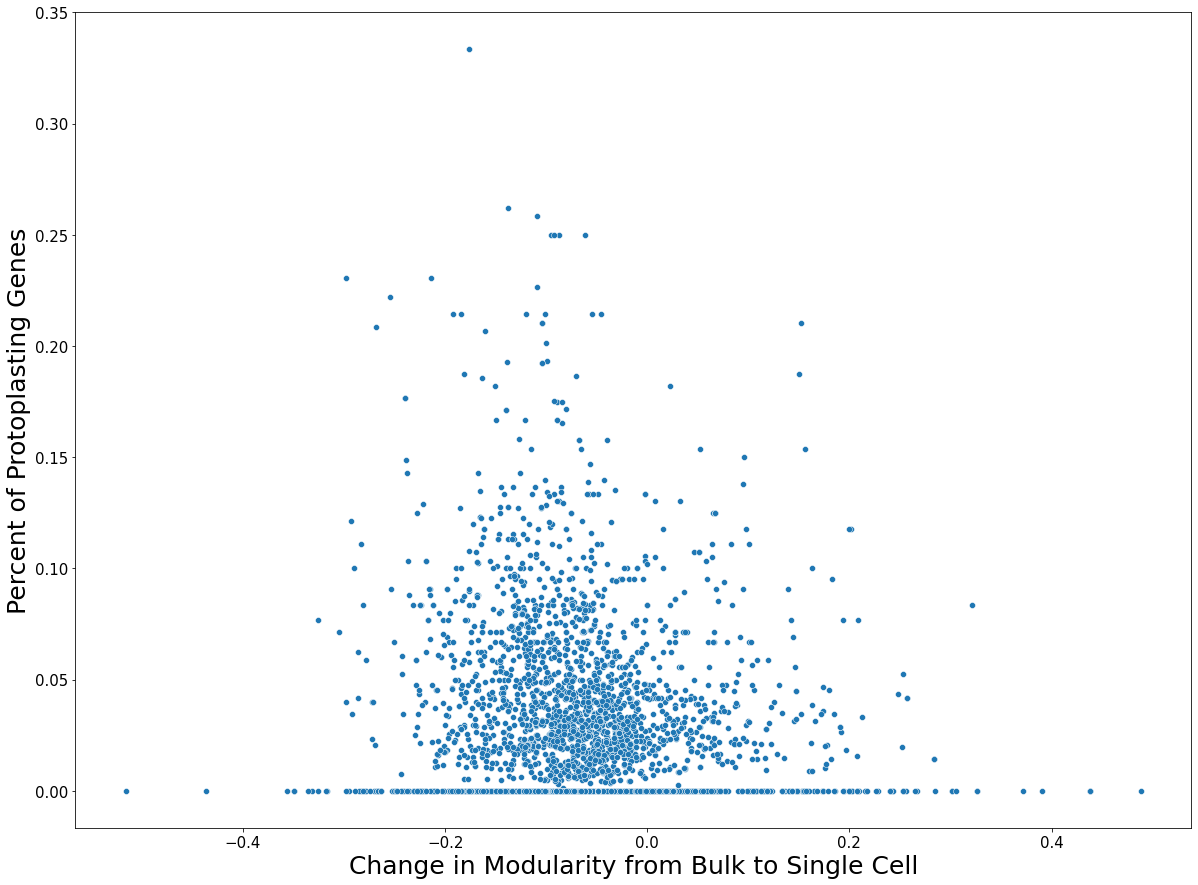

In [170]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_with_differnce_in_columns,y = 'Protoplast Gene',x = 'Gain In Modularity in Single Cell')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.xlabel("Change in Modularity from Bulk to Single Cell", fontsize = 25)
plt.ylabel("Percent of Protoplasting Genes", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 [Text(0, -0.05, '−0.05'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.10000000000000002, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20')])

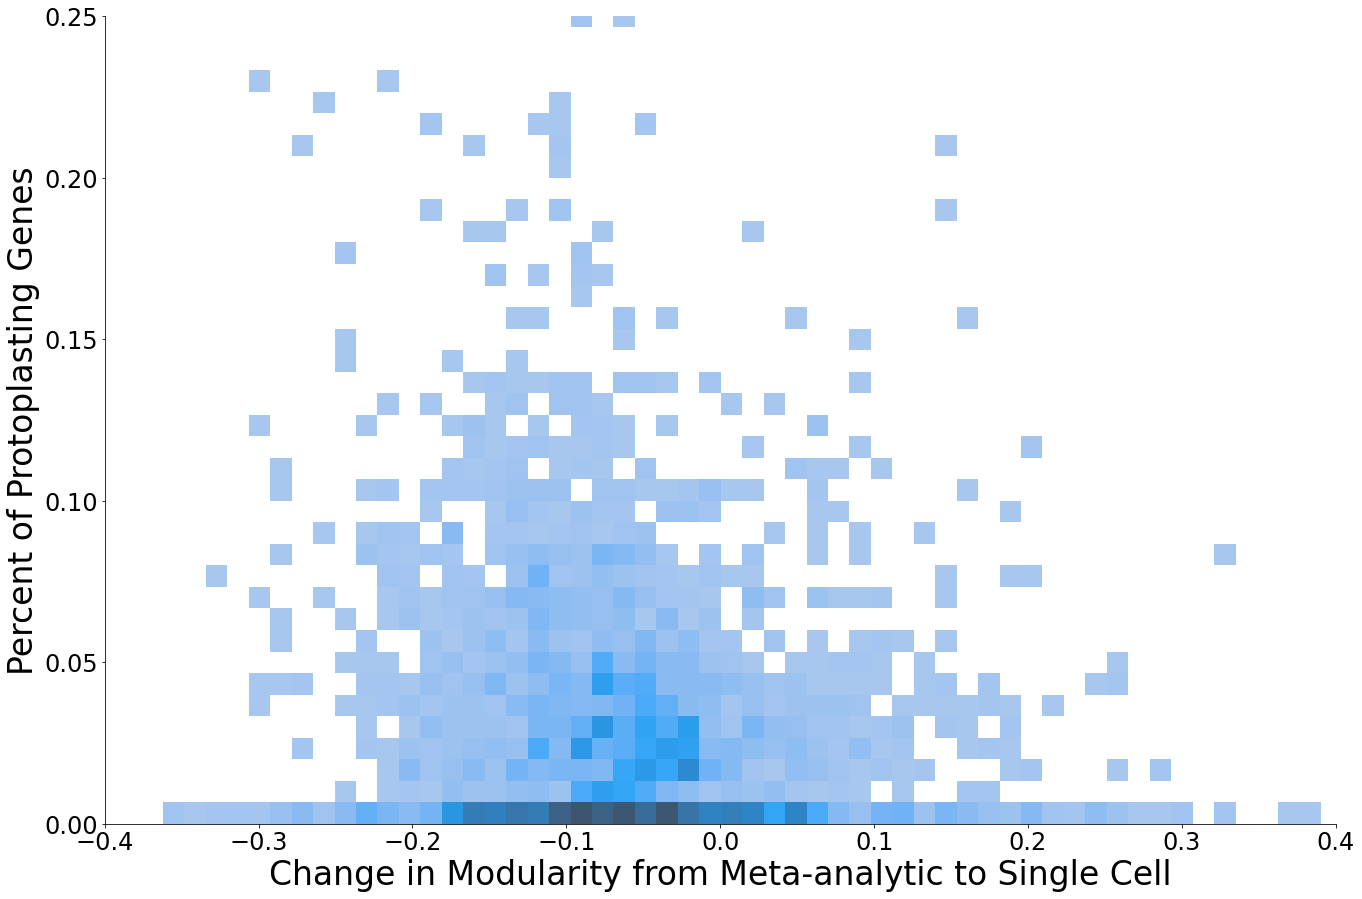

In [259]:
sns.displot(data = slimmed_to_original_with_differnce_in_columns,y = 'Protoplast Gene',x = 'Gain In Modularity in Single Cell', height = 12, aspect = 1.5)
plt.xlim(-.4,.4)
plt.ylim(0,.25)
plt.xlabel("Change in Modularity from Meta-analytic to Single Cell", fontsize = 33)
plt.ylabel("Percent of Protoplasting Genes", fontsize = 33)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [172]:
table_for_committee = slimmed_to_original_with_differnce_in_columns.sort_values(by = 'Gain In Modularity in Single Cell', ascending = False).head(50)
table_for_committee = table_for_committee[['Name','Avg FC','Gain In Modularity in Single Cell']]
table_for_committee = table_for_committee.rename(columns = {'Avg FC':'Average Conservation of Coexpression Partners','Gain In Modularity in Single Cell':'Increase in Single Cell Modularity Compared to Meta Analystic Modularity'})
table_for_committee = table_for_committee.drop(['GO:0035592','GO:0071692','GO:0009306','GO:0030119','GO:0090113','GO:0030663','GO:0048475','GO:0030137','GO:0140029','GO:0019798','GO:0004656','GO:0018401','GO:0046961'])
table_for_committee.head(10)

Name  \
GO:0030131                      clathrin adaptor complex   
GO:0002790                             peptide secretion   
GO:0003400           regulation of COPII vesicle coating   
GO:0016408                    C-acyltransferase activity   
GO:0033176     proton-transporting V-type ATPase complex   
GO:0030126                             COPI vesicle coat   
GO:0010496                       intercellular transport   
GO:0030117                                 membrane coat   
GO:0033179  proton-transporting V-type ATPase, V0 domain   
GO:0006904        vesicle docking involved in exocytosis   

            Average Conservation of Coexpression Partners  \
GO:0030131                                       0.868312   
GO:0002790                                       0.809298   
GO:0003400                                       0.787529   
GO:0016408                                       0.658338   
GO:0033176                                       0.858111   
GO:0030126                                       0.819468   
GO:0010496                                       0.674616   
GO:0030117                                       0.826072   
GO:0033179                                       0.846308   
GO:0006904                                       0.819257   

            Increase in Single Cell Modularity Compared to Meta Analystic Modularity  
GO:0030131                                           0.488265                         
GO:0002790                                           0.437838                         
GO:0003400                                           0.326403                         
GO:0016408                                           0.321051                         
GO:0033176                                           0.305870                         
GO:0030126                                           0.301224                         
GO:0010496                                           0.284495                         
GO:0030117                                           0.283618                         
GO:0033179                                           0.265030                         
GO:0006904                                           0.257295

In [173]:
many_go_group_df = pd.DataFrame(columns =['Module Expression','Tissue Type','GO Group'])

for go_group_interest in slimmed_to_original_with_differnce_in_columns.sort_values(by = 'Gain In Modularity in Single Cell', ascending = False).head(5).index.to_list():
    GO_group = go_group_interest
    genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas[GO_group] == 1].index.to_list()
    genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
    expression_levels = single_cell_expression_levels_per_cell_type.loc[genes_of_interest]
    expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type','GO Group'])
    for tissue_type in np.arange(1,10):
        current_type = f"Type {tissue_type}"
        df_with_this_type = expression_levels.filter(like = current_type)
        mean_module_expression = df_with_this_type.mean()
        for index, values in mean_module_expression.iteritems():
            list_to_append = [[values,current_type,go_group_interest]]
            df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type','GO Group'], data = list_to_append)
            expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)
    many_go_group_df = many_go_group_df.append(expression_of_genes_of_interest_df, ignore_index= True)

In [174]:
many_go_group_df

Module Expression Tissue Type    GO Group
0             1.364263      Type 1  GO:0030131
1             1.065023      Type 1  GO:0030131
2             1.677623      Type 1  GO:0030131
3             0.364328      Type 1  GO:0030131
4             2.722607      Type 2  GO:0030131
..                 ...         ...         ...
140           0.958120      Type 7  GO:0009306
141           1.596160      Type 8  GO:0009306
142           0.872577      Type 8  GO:0009306
143           1.927012      Type 9  GO:0009306
144           2.612147      Type 9  GO:0009306

[145 rows x 3 columns]

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

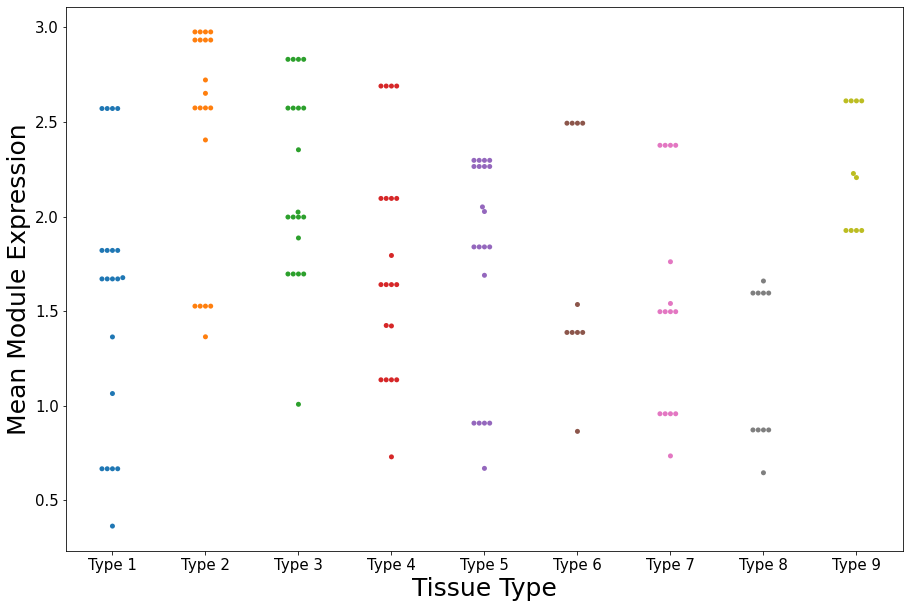

In [175]:
fig, ax = plt.subplots(figsize = (15,10))
sns.swarmplot(data = many_go_group_df, x = 'Tissue Type', y = 'Module Expression' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Mean Module Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)


In [176]:
file_to_read = open('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/dictionary_of_subset_single_celldata.pickle', 'rb')
dictionary_of_subset_single_cell_data = pickle.load(file_to_read)
file_to_read.close()

In [177]:
dictionary_of_subset_single_cell_data

{'Dataset 1 Tissue Type 1': View of AnnData object with n_obs × n_vars = 690 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 2 Tissue Type 1': View of AnnData object with n_obs × n_vars = 1209 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 3 Tissue Type 1': View of AnnData object with n_obs × n_vars = 1210 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 4 Tissue Type 1': View of AnnData object with n_obs × n_vars = 1175 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 1 Tissue Type 2': View of AnnData object with n_obs × n_vars = 730 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 2 Tissue Type 2': View of AnnData object with n_obs × n_vars = 534 × 22271
     obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster',
 'Dataset 3 Tissue Type 2': View of AnnData object with

In [178]:
clathrin_genes

['AT1G10730',
 'AT1G23900',
 'AT1G56590',
 'AT1G60070',
 'AT1G60780',
 'AT2G20790',
 'AT4G11380',
 'AT4G23460',
 'AT4G24550',
 'AT5G11490',
 'AT5G22770',
 'AT5G22780',
 'AT5G46630']

In [179]:
df_of_individual_cell_avg_module_expression = pd.DataFrame(columns =['Module Expression','Tissue Type','Dataset Number'])
for key in dictionary_of_subset_single_cell_data.keys():
    current_single_cell = dictionary_of_subset_single_cell_data[key]
    current_single_cell = current_single_cell[:, current_single_cell.var.index.isin(clathrin_genes)]
    mean_module_for_each_cell = current_single_cell.X.mean(axis = 1)
    current_tissue_type = f'Type {key.split()[-1]}'
    current_dataset = f'Dataset {key.split()[1]}'
    indiv_dataframe = pd.DataFrame(columns=['Module Expression'], data = mean_module_for_each_cell)
    indiv_dataframe['Tissue Type'] = current_tissue_type
    indiv_dataframe['Dataset Number'] = current_dataset 
    df_of_individual_cell_avg_module_expression = df_of_individual_cell_avg_module_expression.append(indiv_dataframe, ignore_index = True)   


In [180]:
df_of_individual_cell_avg_module_expression

Module Expression Tissue Type Dataset Number
0               0.862142      Type 1      Dataset 1
1               1.666101      Type 1      Dataset 1
2               2.961333      Type 1      Dataset 1
3               1.604007      Type 1      Dataset 1
4               0.425960      Type 1      Dataset 1
...                  ...         ...            ...
16636           2.966215      Type 9      Dataset 2
16637           3.035316      Type 9      Dataset 2
16638           2.279902      Type 9      Dataset 2
16639           2.825206      Type 9      Dataset 2
16640           0.708559      Type 9      Dataset 2

[16641 rows x 3 columns]

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

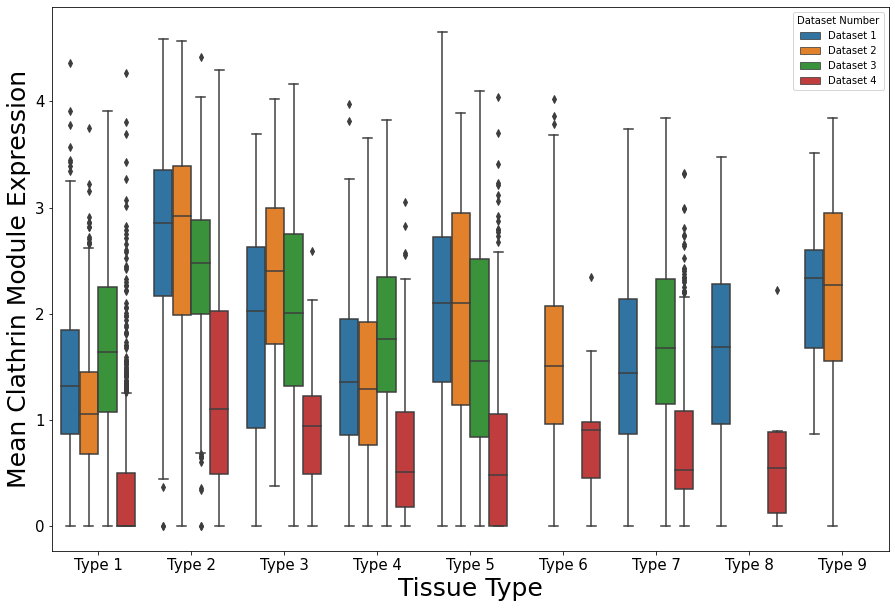

In [181]:
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = df_of_individual_cell_avg_module_expression, x = 'Tissue Type', y = 'Module Expression', hue = 'Dataset Number' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Mean Clathrin Module Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [182]:
def get_individual_cell_results_and_plot(GO_group):
    genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas[GO_group] == 1].index.to_list()
    genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
    df_of_individual_cell_avg_module_expression = pd.DataFrame(columns =['Module Expression','Tissue Type','Dataset Number'])
    for key in dictionary_of_subset_single_cell_data.keys():
        current_single_cell = dictionary_of_subset_single_cell_data[key]
        current_single_cell = current_single_cell[:, current_single_cell.var.index.isin(genes_of_interest)]
        mean_module_for_each_cell = current_single_cell.X.mean(axis = 1)
        current_tissue_type = f'Type {key.split()[-1]}'
        current_dataset = f'Dataset {key.split()[1]}'
        indiv_dataframe = pd.DataFrame(columns=['Module Expression'], data = mean_module_for_each_cell)
        indiv_dataframe['Tissue Type'] = current_tissue_type
        indiv_dataframe['Dataset Number'] = current_dataset 
        df_of_individual_cell_avg_module_expression = df_of_individual_cell_avg_module_expression.append(indiv_dataframe, ignore_index = True)   
    fig, ax = plt.subplots(figsize = (15,10))
    sns.boxplot(data = df_of_individual_cell_avg_module_expression, x = 'Tissue Type', y = 'Module Expression', hue = 'Dataset Number' )
    fig.patch.set_facecolor('white')
    # plt.xlim(.2,.98)
    # plt.ylim(.2,.98)
    plt.ylabel("Mean Clathrin Module Expression", fontsize = 25)
    plt.xlabel("Tissue Type", fontsize = 25)
    #plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
    #plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)


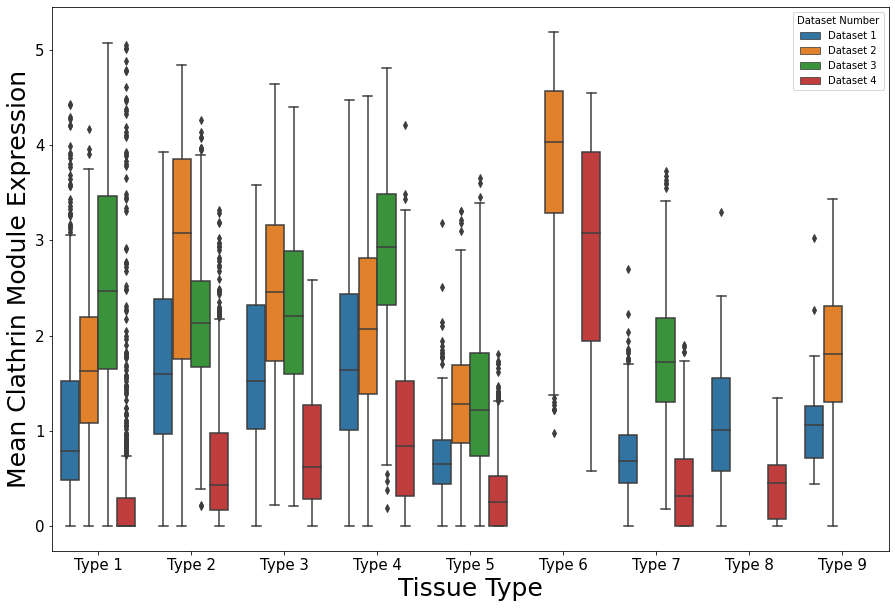

In [183]:
get_individual_cell_results_and_plot('GO:0033290') ## Ribosomal Group

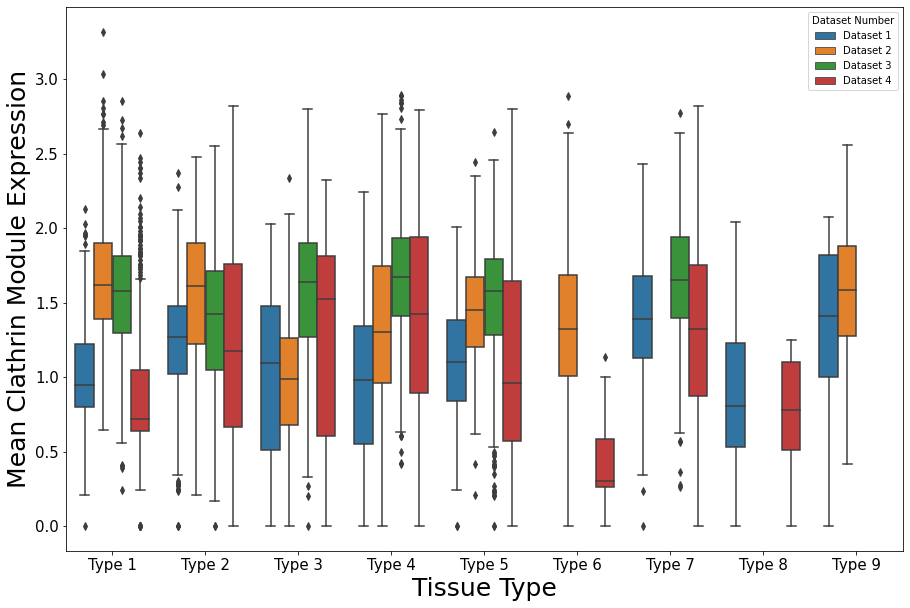

In [184]:
get_individual_cell_results_and_plot('GO:0031407') ## Secondary Group With loss of modularity in single cell

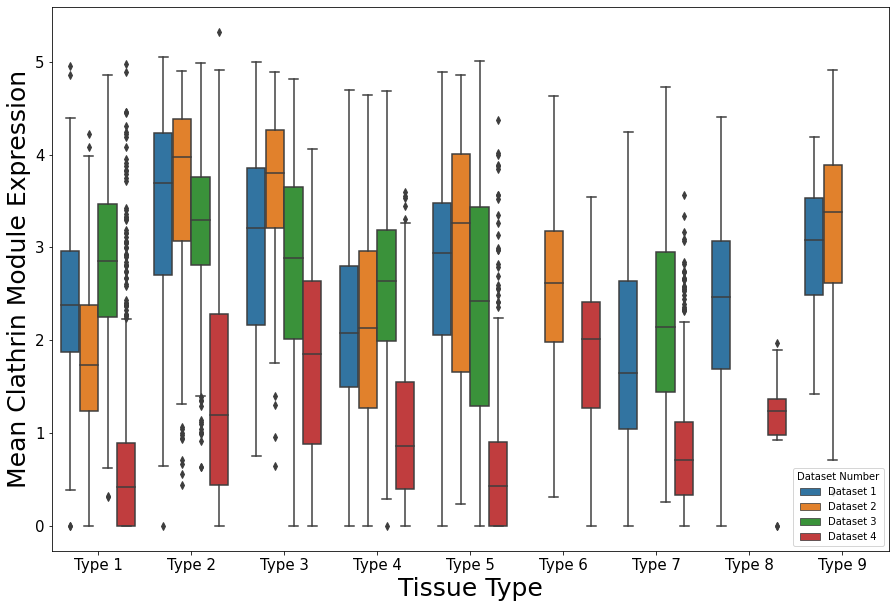

In [185]:
get_individual_cell_results_and_plot('GO:0030126')

In [186]:
slimmed_to_original_with_differnce_in_columns.loc[slimmed_to_original_with_differnce_in_columns['Annotation']== 'Ribosomal']


Avg FC  Avg EGAD  \
GO:0000027  0.937799  0.912810   
GO:0000028  0.946437  0.856894   
GO:0000054  0.836696  0.835784   
GO:0000055  0.884006  0.869709   
GO:0000154  0.895120  0.923098   
GO:0000313  0.895316  0.856168   
GO:0000314  0.917884  0.804370   
GO:0000315  0.886112  0.865338   
GO:0000460  0.900348  0.864755   
GO:0000462  0.936881  0.881393   
GO:0000463  0.941006  0.904888   
GO:0000466  0.898428  0.883729   
GO:0000469  0.899850  0.873033   
GO:0000470  0.936906  0.904360   
GO:0000478  0.925667  0.914585   
GO:0000479  0.936024  0.909031   
GO:0003735  0.923273  0.878232   
GO:0005732  0.902656  0.952947   
GO:0005840  0.895963  0.836113   
GO:0005844  0.934310  0.865655   
GO:0006364  0.887749  0.862352   
GO:0008097  0.889908  0.853839   
GO:0008649  0.899305  0.871324   
GO:0015934  0.942800  0.906577   
GO:0015935  0.946621  0.888063   
GO:0016072  0.887106  0.858226   
GO:0016075  0.864266  0.787192   
GO:0016282  0.901965  0.777487   
GO:0019843  0.930780  0.885657   
GO:0022625  0.950283  0.918538   
GO:0022626  0.912012  0.859668   
GO:0022627  0.953155  0.898583   
GO:0030490  0.934178  0.886427   
GO:0030684  0.919476  0.900295   
GO:0030686  0.928378  0.929379   
GO:0030687  0.909982  0.894505   
GO:0031125  0.893788  0.855750   
GO:0031167  0.897580  0.866816   
GO:0032040  0.930737  0.907536   
GO:0033290  0.903622  0.778770   
GO:0033750  0.836696  0.835784   
GO:0042254  0.895949  0.866076   
GO:0042255  0.932036  0.886420   
GO:0042273  0.932171  0.906506   
GO:0042274  0.936311  0.885688   
GO:0043022  0.843441  0.704883   
GO:0044391  0.944263  0.902013   
GO:0070180  0.940876  0.912684   
GO:0070181  0.944852  0.783758   
GO:0070475  0.902599  0.888107   
GO:0071428  0.853597  0.815119   
GO:0140102  0.881943  0.842588   
GO:1901259  0.893458  0.873169   

                                                         Name  \
GO:0000027                   ribosomal large subunit assembly   
GO:0000028                   ribosomal small subunit assembly   
GO:0000054              ribosomal subunit export from nucleus   
GO:0000055        ribosomal large subunit export from nucleus   
GO:0000154                                  rRNA modification   
GO:0000313                                organellar ribosome   
GO:0000314                 organellar small ribosomal subunit   
GO:0000315                 organellar large ribosomal subunit   
GO:0000460                            maturation of 5.8S rRNA   
GO:0000462  maturation of SSU-rRNA from tricistronic rRNA ...   
GO:0000463  maturation of LSU-rRNA from tricistronic rRNA ...   
GO:0000466  maturation of 5.8S rRNA from tricistronic rRNA...   
GO:0000469               cleavage involved in rRNA processing   
GO:0000470                             maturation of LSU-rRNA   
GO:0000478  endonucleolytic cleavage involved in rRNA proc...   
GO:0000479  endonucleolytic cleavage of tricistronic rRNA ...   
GO:0003735                 structural constituent of ribosome   
GO:0005732          small nucleolar ribonucleoprotein complex   
GO:0005840                                           ribosome   
GO:0005844                                           polysome   
GO:0006364                                    rRNA processing   
GO:0008097                                    5S rRNA binding   
GO:0008649                    rRNA methyltransferase activity   
GO:0015934                            large ribosomal subunit   
GO:0015935                            small ribosomal subunit   
GO:0016072                             rRNA metabolic process   
GO:0016075                             rRNA catabolic process   
GO:0016282               eukaryotic 43S preinitiation complex   
GO:0019843                                       rRNA binding   
GO:0022625                  cytosolic large ribosomal subunit   
GO:0022626                                 cytosolic ribosome   
GO:0022627                  cytosolic small ribosomal subunit   
GO:0030490                      

In [187]:
slimmed_to_original_with_differnce_in_columns.loc['GO:0031407']

Avg FC                                                 0.632553
Avg EGAD                                               0.847979
Name                                 oxylipin metabolic process
Single Cell Group                                      0.549966
Annotation                                 Secondary Metabolism
Protoplast Gene                                        0.230769
Gain In Modularity in Single Cell                     -0.298013
Name: GO:0031407, dtype: object

In [188]:
genes_detected_per_type = pd.DataFrame(columns = single_cell_expression_levels_per_cell_type.columns)
genes_detected_per_type.loc[0] = single_cell_expression_levels_per_cell_type.mask(single_cell_expression_levels_per_cell_type >0, other = 1).sum().to_list()
genes_detected_per_type

Dataset 1 Tissue Type 1  Dataset 2 Tissue Type 1  Dataset 3 Tissue Type 1  \
0                  17625.0                  19601.0                  20382.0   

   Dataset 4 Tissue Type 1  Dataset 1 Tissue Type 2  Dataset 2 Tissue Type 2  \
0                  19282.0                  17640.0                  20151.0   

   Dataset 3 Tissue Type 2  Dataset 4 Tissue Type 2  Dataset 1 Tissue Type 3  \
0                  19867.0                  20307.0                  13618.0   

   Dataset 2 Tissue Type 3  ...  Dataset 4 Tissue Type 5  \
0                  17370.0  ...                  18702.0   

   Dataset 2 Tissue Type 6  Dataset 4 Tissue Type 6  Dataset 1 Tissue Type 7  \
0                  20402.0                  12673.0                  15502.0   

   Dataset 3 Tissue Type 7  Dataset 4 Tissue Type 7  Dataset 1 Tissue Type 8  \
0                  19779.0                  18047.0                  14663.0   

   Dataset 4 Tissue Type 8  Dataset 1 Tissue Type 9  Dataset 2 Tissue Type 9  
0                   5929.0                  10188.0                  17117.0  

[1 rows x 29 columns]

(array([ 4000.,  6000.,  8000., 10000., 12000., 14000., 16000., 18000.,
        20000., 22000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

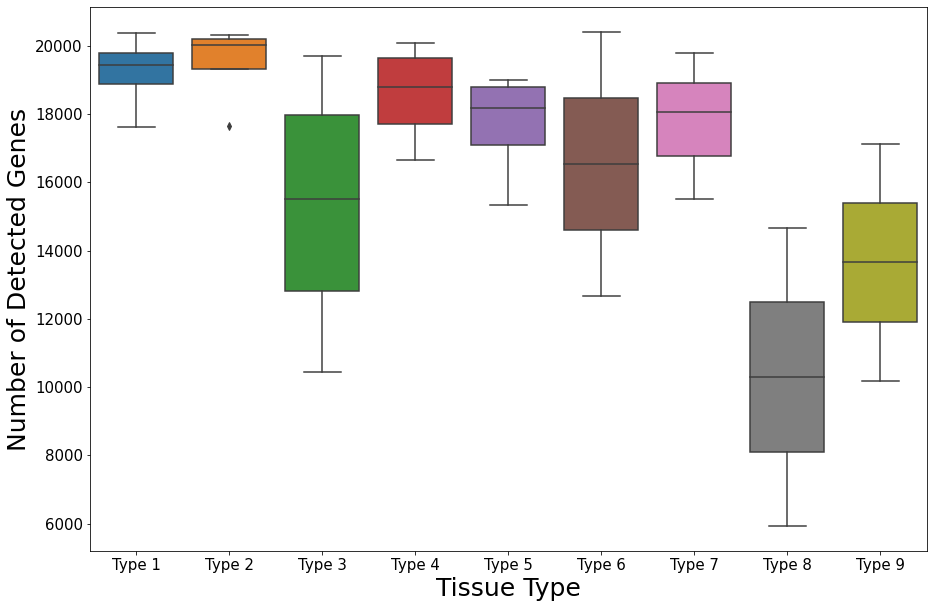

In [189]:
expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])

for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = genes_detected_per_type.filter(like = current_type)
    mean_module_expression = df_with_this_type.mean()
    for index, values in mean_module_expression.iteritems():
        list_to_append = [[values,current_type]]
        df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)
        expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = expression_of_genes_of_interest_df, x = 'Tissue Type', y = 'Module Expression' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Number of Detected Genes", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [190]:
mean_module_expression

Dataset 1 Tissue Type 9    10188.0
Dataset 2 Tissue Type 9    17117.0
dtype: float64

In [191]:
genes_detected_per_type

Dataset 1 Tissue Type 1  Dataset 2 Tissue Type 1  Dataset 3 Tissue Type 1  \
0                  17625.0                  19601.0                  20382.0   

   Dataset 4 Tissue Type 1  Dataset 1 Tissue Type 2  Dataset 2 Tissue Type 2  \
0                  19282.0                  17640.0                  20151.0   

   Dataset 3 Tissue Type 2  Dataset 4 Tissue Type 2  Dataset 1 Tissue Type 3  \
0                  19867.0                  20307.0                  13618.0   

   Dataset 2 Tissue Type 3  ...  Dataset 4 Tissue Type 5  \
0                  17370.0  ...                  18702.0   

   Dataset 2 Tissue Type 6  Dataset 4 Tissue Type 6  Dataset 1 Tissue Type 7  \
0                  20402.0                  12673.0                  15502.0   

   Dataset 3 Tissue Type 7  Dataset 4 Tissue Type 7  Dataset 1 Tissue Type 8  \
0                  19779.0                  18047.0                  14663.0   

   Dataset 4 Tissue Type 8  Dataset 1 Tissue Type 9  Dataset 2 Tissue Type 9  
0                   5929.0                  10188.0                  17117.0  

[1 rows x 29 columns]

In [192]:
len(single_cell_expression_levels_per_cell_type.mask(single_cell_expression_levels_per_cell_type >0, other = 1).sum().values)

29

Dataset 1 Tissue Type 1    17625.0
Dataset 2 Tissue Type 1    19601.0
Dataset 3 Tissue Type 1    20382.0
Dataset 4 Tissue Type 1    19282.0
Dataset 1 Tissue Type 2    17640.0
Dataset 2 Tissue Type 2    20151.0
Dataset 3 Tissue Type 2    19867.0
Dataset 4 Tissue Type 2    20307.0
Dataset 1 Tissue Type 3    13618.0
Dataset 2 Tissue Type 3    17370.0
Dataset 3 Tissue Type 3    19706.0
Dataset 4 Tissue Type 3    10436.0
Dataset 1 Tissue Type 4    16664.0
Dataset 2 Tissue Type 4    19497.0
Dataset 3 Tissue Type 4    20091.0
Dataset 4 Tissue Type 4    18055.0
Dataset 1 Tissue Type 5    15329.0
Dataset 2 Tissue Type 5    17666.0
Dataset 3 Tissue Type 5    18996.0
Dataset 4 Tissue Type 5    18702.0
Dataset 2 Tissue Type 6    20402.0
Dataset 4 Tissue Type 6    12673.0
Dataset 1 Tissue Type 7    15502.0
Dataset 3 Tissue Type 7    19779.0
Dataset 4 Tissue Type 7    18047.0
Dataset 1 Tissue Type 8    14663.0
Dataset 4 Tissue Type 8     5929.0
Dataset 1 Tissue Type 9    10188.0
Dataset 2 Tissue Typ

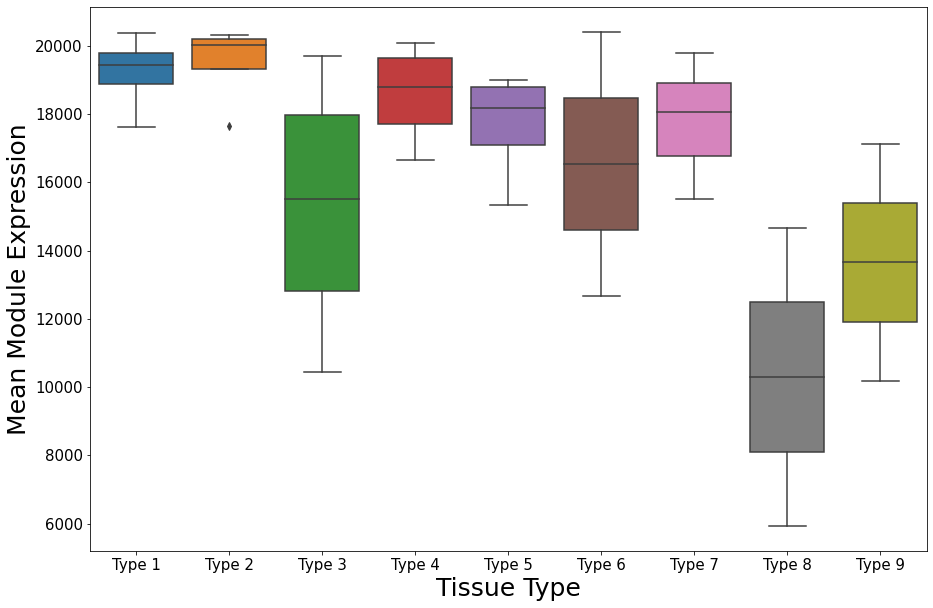

In [193]:
single_cell_expression_levels_per_cell_type.mask(single_cell_expression_levels_per_cell_type >0, other = 1).sum()
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = expression_of_genes_of_interest_df, x = 'Tissue Type', y = 'Module Expression' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Mean Module Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
single_cell_expression_levels_per_cell_type.mask(single_cell_expression_levels_per_cell_type >0, other = 1).sum()

(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

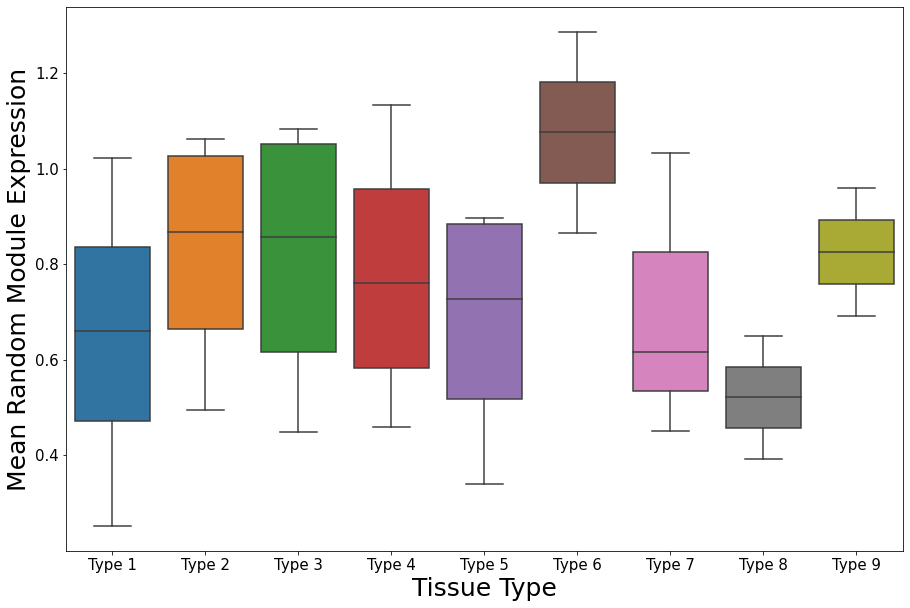

In [194]:
random_genes = single_cell_expression_levels_per_cell_type.sample(n = 20)
expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = random_genes.filter(like = current_type)
    mean_module_expression = df_with_this_type.mean()
    for index, values in mean_module_expression.iteritems():
        list_to_append = [[values,current_type]]
        df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)
        expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = expression_of_genes_of_interest_df, x = 'Tissue Type', y = 'Module Expression' )
fig.patch.set_facecolor('white')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Mean Random Module Expression", fontsize = 25)
plt.xlabel("Tissue Type", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [195]:
quantiles_of_all_genes = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/quantiles_of_single_cell_genes.csv', index_col = 0)
quantiles_of_all_genes

Quantile
AT1G01010         8
AT1G01020         8
AT1G01030         5
AT1G01040         6
AT1G01050        10
...             ...
ATCG01110         3
ATCG01120         3
ATCG01130        10
ATCG01230         1
ATCG01310         1

[22271 rows x 1 columns]

In [196]:
def plot_go_group_plot_quantile_matched_random_genes(GO_group):
    genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas[GO_group] == 1].index.to_list()
    genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
    list_of_expression_matched_genes = []
    genes_of_interest_quantiles = quantiles_of_all_genes.loc[genes_of_interest]
    expression_levels = single_cell_expression_levels_per_cell_type.loc[genes_of_interest]
    for quantile in genes_of_interest_quantiles['Quantile']:
        random_gene_in_quantile = quantiles_of_all_genes.loc[quantiles_of_all_genes['Quantile'] == quantile].sample(n =1).index.to_list()
        list_of_expression_matched_genes.extend(random_gene_in_quantile)
    expression_levels = single_cell_expression_levels_per_cell_type.loc[list_of_expression_matched_genes]
    expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])
    for tissue_type in np.arange(1,10):
        current_type = f"Type {tissue_type}"
        df_with_this_type = expression_levels.filter(like = current_type)
        mean_module_expression = df_with_this_type.mean()
        for index, values in mean_module_expression.iteritems():
            list_to_append = [[values,current_type]]
            df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)
            expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)
    fig, ax = plt.subplots(figsize = (15,10))
    sns.boxplot(data = expression_of_genes_of_interest_df, x = 'Tissue Type', y = 'Module Expression' )
    fig.patch.set_facecolor('white')
    # plt.xlim(.2,.98)
    # plt.ylim(.2,.98)
    plt.ylabel("Quantile Matched Module Expression", fontsize = 25)
    plt.xlabel("Tissue Type", fontsize = 25)
    #plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
    #plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

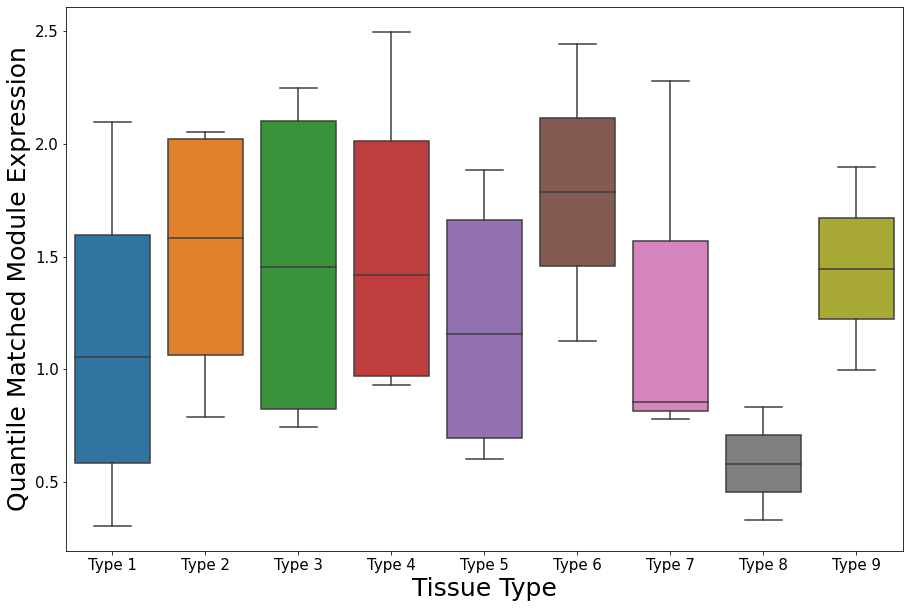

In [197]:
plot_go_group_plot_quantile_matched_random_genes('GO:0030131')

In [198]:
genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas['GO:0030126'] == 1].index.to_list()
genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
genes_of_interest_quantiles = quantiles_of_all_genes.loc[genes_of_interest]
expression_levels = single_cell_expression_levels_per_cell_type.loc[genes_of_interest]
expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = expression_levels.filter(like = current_type)
    mean_module_expression = df_with_this_type.mean()
    for index, values in mean_module_expression.iteritems():
        list_to_append = [[values,current_type]]
        df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)
        expression_of_genes_of_interest_df = expression_of_genes_of_interest_df.append(df_to_append, ignore_index= True)

In [199]:
genes_of_interest_quantiles

Quantile
AT1G52360         9
AT4G08520        10
AT2G21390         9
AT2G34840         8
AT3G09800         7
AT1G30630        10
AT1G79990        10
AT1G62020         9
AT3G15980         9
AT4G31480        10
AT1G15370        10
AT1G60970         2
AT5G05010        10
AT4G34450        10
AT4G31490         9

In [200]:
expression_levels = single_cell_expression_levels_per_cell_type.loc[genes_of_interest]
expression_of_genes_of_interest_df = pd.DataFrame(columns =['Module Expression','Tissue Type'])
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = expression_levels.filter(like = current_type)
    mean_module_expression = df_with_this_type.mean()
    for index, values in mean_module_expression.iteritems():
        list_to_append = [[values,current_type]]
        df_to_append  = pd.DataFrame(columns = ['Module Expression','Tissue Type'], data = list_to_append)

In [201]:
single_cell_expression_levels_per_cell_type

Dataset 1 Tissue Type 1  Dataset 2 Tissue Type 1  \
AT1G01010                 0.121605                 0.523011   
AT1G01020                 0.366243                 0.929447   
AT1G01030                 0.031003                 0.252739   
AT1G01040                 0.090848                 0.215309   
AT1G01050                 3.273052                 3.072888   
...                            ...                      ...   
ATCG01110                 0.000000                 0.003474   
ATCG01120                 0.005455                 0.011101   
ATCG01130                 1.070228                 1.122886   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.000000   

           Dataset 3 Tissue Type 1  Dataset 4 Tissue Type 1  \
AT1G01010                 0.595947                 0.129706   
AT1G01020                 2.021641                 0.243215   
AT1G01030                 0.225411                 0.007583   
AT1G01040                 0.259004                 0.107929   
AT1G01050                 5.361505                 0.947332   
...                            ...                      ...   
ATCG01110                 0.012186                 0.108181   
ATCG01120                 0.026325                 0.162838   
ATCG01130                 2.159980                 1.014451   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.003550   

           Dataset 1 Tissue Type 2  Dataset 2 Tissue Type 2  \
AT1G01010                 0.585265                 0.304047   
AT1G01020                 0.725181                 1.691138   
AT1G01030                 0.000000                 0.166507   
AT1G01040                 0.130403                 0.320185   
AT1G01050                 3.577862                 4.785543   
...                            ...                      ...   
ATCG01110                 0.005697                 0.008769   
ATCG01120                 0.057938                 0.035758   
ATCG01130                 2.460740                 2.929678   
ATCG01230                 0.000000                 0.000000   
ATCG01310                 0.000000                 0.000000   

           Dataset 3 Tissue Type 2  Dataset 4 Tissue Type 2  \
AT1G01010                 1.103968                 2.193456   
AT1G01020                 2.851870                 0.706450   
AT1G01030                 0.022735                 0.021803   
AT1G01040                 0.216974                 0.197384   
AT1G01050                 4.398198                 1.371240   
...                            ...                      ...   
ATCG01110                 0.005439                 0.169166   
ATCG01120                 0.017484                 0.264577   
ATCG01130                 1.805271                 2.724424   
ATCG01230                 0.000000                 0.001495   
ATCG01310                 0.000000                 0.007055   

           Dataset 1 Tissue Type 3  Dataset 2 Tissue Type 3  ...  \
AT1G01010                 0.548165                 0.146582  ...   
AT1G01020                 0.222234                 1.581122  ...   
AT1G01030                 0.000000                 0.000000  ...   
AT1G01040                 0.467154                 0.642848  ...   
AT1G01050                 4.070703                 4.862555  ...   
...                            ...                      ...  ...   
ATCG01110                 0.000000                 0.000000  ...   
ATCG01120                 0.000000                 0.052588  ...   
ATCG01130                 3.215276                 1.833990  ...   
ATCG01230                 0.000000                 0.000000  ...   
ATCG01310                 0.000000                 0.000000  ...   

           Dataset 4 Tissue Type 5  Dataset 2 Tissue Type 6  \
AT1G01010                 2.133073                 0.365322   
AT1G01020                 0.408642      

In [202]:
tissue_type_name_list =[]
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    tissue_type_name_list.append(current_type)
tissue_type_name_list

['Type 1',
 'Type 2',
 'Type 3',
 'Type 4',
 'Type 5',
 'Type 6',
 'Type 7',
 'Type 8',
 'Type 9']

In [203]:
single_cell_avged_across_datasets_single_cell_expression = pd.DataFrame(index = single_cell_expression_levels_per_cell_type.index,columns = tissue_type_name_list)
single_cell_avged_across_datasets_single_cell_expression

Type 1 Type 2 Type 3 Type 4 Type 5 Type 6 Type 7 Type 8 Type 9
AT1G01010    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
AT1G01020    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
AT1G01030    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
AT1G01040    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
AT1G01050    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
...          ...    ...    ...    ...    ...    ...    ...    ...    ...
ATCG01110    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
ATCG01120    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
ATCG01130    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
ATCG01230    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
ATCG01310    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

[22271 rows x 9 columns]

In [204]:
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = single_cell_expression_levels_per_cell_type.filter(like = current_type)
    single_cell_avged_across_datasets_single_cell_expression[current_type] = df_with_this_type.mean(axis =1)


In [205]:
avged_datasets_corr_results_across_all_genes = single_cell_avged_across_datasets_single_cell_expression.corr(method = 'spearman')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Type 1'),
  Text(0, 1.5, 'Type 2'),
  Text(0, 2.5, 'Type 3'),
  Text(0, 3.5, 'Type 4'),
  Text(0, 4.5, 'Type 5'),
  Text(0, 5.5, 'Type 6'),
  Text(0, 6.5, 'Type 7'),
  Text(0, 7.5, 'Type 8'),
  Text(0, 8.5, 'Type 9')])

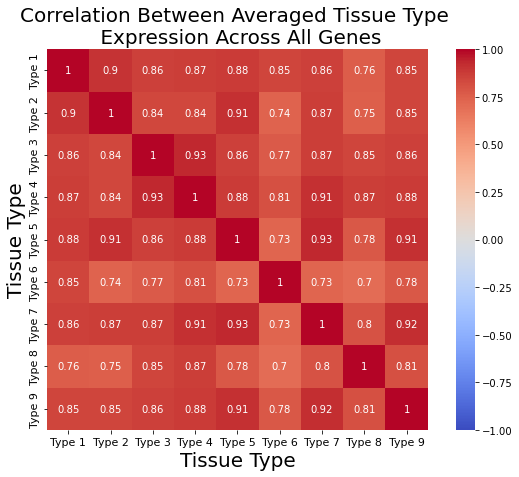

In [206]:
fig, ax = plt.subplots(figsize = (10,7))
fig.patch.set_facecolor('white')
ax = sns.heatmap(avged_datasets_corr_results_across_all_genes.round(2), center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm',annot= True, square = True)
plt.ylabel("Tissue Type", fontsize = 20)
plt.xlabel("Tissue Type", fontsize = 20)

#sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Correlation Between Averaged Tissue Type \n Expression Across All Genes", fontsize = 20)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

In [207]:
slimmed_to_original_with_differnce_in_columns

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051181  0.703080  0.595093                               NaN   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group Annotation  Protoplast Gene  \
GO:0000003           0.585704       None         0.019004   
GO:0000018           0.773632       None         0.000000   
GO:0000027           0.823763  Ribosomal         0.020833   
GO:0000028           0.742855  Ribosomal         0.000000   
GO:0000030           0.696564       None         0.000000   
...                       ...        ...              ...   
GO:0051181           0.536078       None         0.044444   
GO:0051193           0.604822       None         0.076923   
GO:0051184           0.575330       None         0.000000   
GO:0051182           0.595758       None         0.066667   
GO:0051185           0.589837       None         0.000000   

            Gain In Modularity in Single Cell  
GO:0000003                          -0.051711  
GO:0000018                           0.054983  
GO:0000027                          -0.089048  
GO:0000028                          -0.114039  
GO:0000030                           0.008300  
...                                       ...  
GO:0051181                          -0.059015  
GO:0051193                          -0.051699  
GO:0051184                           0.156842  
GO:0051182                           0.078600  
GO:0051185                           0.047466  

[2931 rows x 7 columns]

In [208]:
module_avg_expression_in_each_dataset_tissue = pd.DataFrame(index = slimmed_to_original_with_differnce_in_columns.index, columns = single_cell_expression_levels_per_cell_type.columns)
module_avg_expression_in_each_dataset_tissue

Dataset 1 Tissue Type 1 Dataset 2 Tissue Type 1  \
GO:0000003                     NaN                     NaN   
GO:0000018                     NaN                     NaN   
GO:0000027                     NaN                     NaN   
GO:0000028                     NaN                     NaN   
GO:0000030                     NaN                     NaN   
...                            ...                     ...   
GO:0051181                     NaN                     NaN   
GO:0051193                     NaN                     NaN   
GO:0051184                     NaN                     NaN   
GO:0051182                     NaN                     NaN   
GO:0051185                     NaN                     NaN   

           Dataset 3 Tissue Type 1 Dataset 4 Tissue Type 1  \
GO:0000003                     NaN                     NaN   
GO:0000018                     NaN                     NaN   
GO:0000027                     NaN                     NaN   
GO:0000028                     NaN                     NaN   
GO:0000030                     NaN                     NaN   
...                            ...                     ...   
GO:0051181                     NaN                     NaN   
GO:0051193                     NaN                     NaN   
GO:0051184                     NaN                     NaN   
GO:0051182                     NaN                     NaN   
GO:0051185                     NaN                     NaN   

           Dataset 1 Tissue Type 2 Dataset 2 Tissue Type 2  \
GO:0000003                     NaN                     NaN   
GO:0000018                     NaN                     NaN   
GO:0000027                     NaN                     NaN   
GO:0000028                     NaN                     NaN   
GO:0000030                     NaN                     NaN   
...                            ...                     ...   
GO:0051181                     NaN                     NaN   
GO:0051193                     NaN                     NaN   
GO:0051184                     NaN                     NaN   
GO:0051182                     NaN                     NaN   
GO:0051185                     NaN                     NaN   

           Dataset 3 Tissue Type 2 Dataset 4 Tissue Type 2  \
GO:0000003                     NaN                     NaN   
GO:0000018                     NaN                     NaN   
GO:0000027                     NaN                     NaN   
GO:0000028                     NaN                     NaN   
GO:0000030                     NaN                     NaN   
...                            ...                     ...   
GO:0051181                     NaN                     NaN   
GO:0051193                     NaN                     NaN   
GO:0051184                     NaN                     NaN   
GO:0051182                     NaN                     NaN   
GO:0051185                     NaN                     NaN   

           Dataset 1 Tissue Type 3 Dataset 2 Tissue Type 3  ...  \
GO:0000003                     NaN                     NaN  ...   
GO:0000018                     NaN                     NaN  ...   
GO:0000027                     NaN                     NaN  ...   
GO:0000028                     NaN                     NaN  ...   
GO:0000030                     NaN                     NaN  ...   
...                            ...                     ...  ...   
GO:0051181                     NaN                     NaN  ...   
GO:0051193                     NaN                     NaN  ...   
GO:0051184                     NaN                     NaN  ...   
GO:0051182                     NaN                     NaN  ...   
GO:0051185                     NaN                     NaN  ...   

           Dataset 4 Tissue Type 5 Dataset 2 Tissue Type 6  \
GO:0000003                     NaN                     NaN   
GO:0000018                     NaN                     NaN   
GO:0000027                     NaN      

In [209]:
for module in module_avg_expression_in_each_dataset_tissue.index.to_list():
    genes_of_interest = arab_genes_to_pandas.loc[arab_genes_to_pandas[module] == 1].index.to_list()
    genes_of_interest = list(set(single_cell_expression_levels_per_cell_type.index).intersection(set(genes_of_interest)))
    module_avg_expression_in_each_dataset_tissue.loc[module] = single_cell_expression_levels_per_cell_type.loc[genes_of_interest].mean()

In [210]:
module_avg_expression_in_each_dataset_tissue = module_avg_expression_in_each_dataset_tissue.astype(float)
module_avg_expression_in_each_dataset_tissue


Dataset 1 Tissue Type 1  Dataset 2 Tissue Type 1  \
GO:0000003                 0.539934                 0.781454   
GO:0000018                 0.541283                 0.721860   
GO:0000027                 1.602319                 2.204278   
GO:0000028                 1.717891                 2.398839   
GO:0000030                 0.549160                 0.564405   
...                             ...                      ...   
GO:0051181                 0.601714                 0.767616   
GO:0051193                 0.662869                 1.141486   
GO:0051184                 0.253900                 0.485791   
GO:0051182                 0.366297                 0.636904   
GO:0051185                 0.309780                 0.545686   

            Dataset 3 Tissue Type 1  Dataset 4 Tissue Type 1  \
GO:0000003                 0.982620                 0.291301   
GO:0000018                 0.903414                 0.281757   
GO:0000027                 3.041226                 0.547395   
GO:0000028                 3.159484                 0.398871   
GO:0000030                 1.089199                 0.264879   
...                             ...                      ...   
GO:0051181                 1.134853                 0.398863   
GO:0051193                 1.238111                 0.488367   
GO:0051184                 0.930255                 0.116406   
GO:0051182                 1.188132                 0.192119   
GO:0051185                 1.077287                 0.146238   

            Dataset 1 Tissue Type 2  Dataset 2 Tissue Type 2  \
GO:0000003                 0.775009                 1.100093   
GO:0000018                 0.571151                 0.895440   
GO:0000027                 1.642868                 2.811525   
GO:0000028                 1.987488                 3.181940   
GO:0000030                 1.369774                 1.840981   
...                             ...                      ...   
GO:0051181                 1.174401                 1.611935   
GO:0051193                 0.998591                 1.374984   
GO:0051184                 0.458247                 1.088118   
GO:0051182                 0.663870                 1.293981   
GO:0051185                 0.569888                 1.143521   

            Dataset 3 Tissue Type 2  Dataset 4 Tissue Type 2  \
GO:0000003                 0.949052                 0.610728   
GO:0000018                 0.707530                 0.453243   
GO:0000027                 1.606774                 0.539439   
GO:0000028                 1.931155                 0.473251   
GO:0000030                 1.469339                 0.703282   
...                             ...                      ...   
GO:0051181                 1.398134                 1.016964   
GO:0051193                 1.371025                 0.910830   
GO:0051184                 0.865479                 0.292144   
GO:0051182                 1.133455                 0.451319   
GO:0051185                 0.936745                 0.357330   

            Dataset 1 Tissue Type 3  Dataset 2 Tissue Type 3  ...  \
GO:0000003                 0.663152                 0.959992  ...   
GO:0000018                 0.503847                 0.793848  ...   
GO:0000027                 1.811223                 2.290899  ...   
GO:0000028                 2.215811                 2.779792  ...   
GO:0000030                 0.595699                 1.060325  ...   
...                             ...                      ...  ...   
GO:0051181                 0.661113                 1.047725  ...   
GO:0051193                 0.589777                 0.993420  ...   
GO:0051184                 0.266355                 0.653407  ...   
GO:0051182                 0.392775                 0.878933  ...   
GO:0051185                 0.343875                 0.754747  ...   

            Dataset 4 Tissue Type 5  Dataset 2 Tissue Type 6  \
GO:0000003                 0.462378        

In [211]:
module_avgd_across_datasets = pd.DataFrame(index = module_avg_expression_in_each_dataset_tissue.index,columns = tissue_type_name_list)
module_avgd_across_datasets

Type 1 Type 2 Type 3 Type 4 Type 5 Type 6 Type 7 Type 8 Type 9
GO:0000003    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0000018    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0000027    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0000028    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0000030    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
...           ...    ...    ...    ...    ...    ...    ...    ...    ...
GO:0051181    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0051193    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0051184    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0051182    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
GO:0051185    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

[2931 rows x 9 columns]

In [212]:
for tissue_type in np.arange(1,10):
    current_type = f"Type {tissue_type}"
    df_with_this_type = module_avg_expression_in_each_dataset_tissue.filter(like = current_type)
    module_avgd_across_datasets[current_type] = df_with_this_type.mean(axis =1)

In [213]:
corr_of_modules_averaged_across_datasets = module_avgd_across_datasets.corr(method = 'spearman')

In [214]:
gene_correlation_network = single_cell_avged_across_datasets_single_cell_expression.T.corr(method = 'spearman')
gene_correlation_network

AT1G01010  AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  \
AT1G01010   1.000000  -0.316667  -0.166667   0.500000  -0.200000  -0.300000   
AT1G01020  -0.316667   1.000000  -0.100000  -0.400000   0.633333   0.383333   
AT1G01030  -0.166667  -0.100000   1.000000   0.150000  -0.283333   0.500000   
AT1G01040   0.500000  -0.400000   0.150000   1.000000  -0.550000   0.083333   
AT1G01050  -0.200000   0.633333  -0.283333  -0.550000   1.000000   0.266667   
...              ...        ...        ...        ...        ...        ...   
ATCG01110   0.183333   0.300000  -0.316667   0.533333  -0.283333   0.066667   
ATCG01120   0.116667   0.350000  -0.416667   0.450000  -0.166667   0.116667   
ATCG01130   0.116667   0.366667  -0.250000   0.566667  -0.050000   0.350000   
ATCG01230   0.228218   0.045644  -0.068465  -0.502079   0.045644  -0.182574   
ATCG01310  -0.029704   0.148522  -0.128719  -0.782217   0.217832  -0.425763   

           AT1G01070  AT1G01080  AT1G01090  AT1G01100  ...  ATCG01060  \
AT1G01010   0.225943   0.016667  -0.300000  -0.516667  ...   0.069631   
AT1G01020   0.677830   0.383333   0.233333   0.466667  ...   0.330748   
AT1G01030  -0.351468   0.383333   0.600000   0.133333  ...   0.261116   
AT1G01040  -0.251048   0.050000   0.183333  -0.150000  ...  -0.287228   
AT1G01050   0.769881   0.316667   0.233333   0.433333  ...  -0.121854   
...              ...        ...        ...        ...  ...        ...   
ATCG01110   0.108788   0.100000  -0.050000   0.133333  ...  -0.060927   
ATCG01120   0.158997   0.133333  -0.016667   0.200000  ...  -0.156670   
ATCG01130   0.184102   0.366667   0.250000   0.383333  ...  -0.278524   
ATCG01230  -0.045835   0.022822  -0.387970  -0.433614  ...   0.619751   
ATCG01310   0.109373  -0.227734  -0.554483  -0.306946  ...   0.641189   

           ATCG01070  ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  \
AT1G01010   0.066667   0.108788   0.116667   0.150000   0.183333   0.116667   
AT1G01020   0.283333   0.728040   0.183333   0.266667   0.300000   0.350000   
AT1G01030   0.466667   0.066946  -0.100000  -0.366667  -0.316667  -0.416667   
AT1G01040   0.300000   0.083683   0.650000   0.466667   0.533333   0.450000   
AT1G01050   0.316667   0.267785  -0.183333  -0.250000  -0.283333  -0.166667   
...              ...        ...        ...        ...        ...        ...   
ATCG01110   0.083333   0.560674   0.850000   0.966667   1.000000   0.983333   
ATCG01120   0.100000   0.577411   0.866667   0.983333   0.983333   1.000000   
ATCG01130   0.400000   0.602516   0.950000   0.900000   0.916667   0.933333   
ATCG01230  -0.296683  -0.091670  -0.502079  -0.296683  -0.319505  -0.319505   
ATCG01310  -0.514877  -0.248575  -0.782217  -0.514877  -0.495074  -0.495074   

           ATCG01130  ATCG01230  ATCG01310  
AT1G01010   0.116667   0.228218  -0.029704  
AT1G01020   0.366667   0.045644   0.148522  
AT1G01030  -0.250000  -0.068465  -0.128719  
AT1G01040   0.566667  -0.502079  -0.782217  
AT1G01050  -0.050000   0.045644   0.217832  
...              ...        ...        ...  
ATCG01110   0.916667  -0.319505  -0.495074  
ATCG01120   0.933333  -0.319505  -0.495074  
ATCG01130   1.000000  -0.433614  -0.653497  
ATCG01230  -0.433614   1.000000   0.840606  
ATCG01310  -0.653497   0.840606   1.000000  

[22271 rows x 22271 columns]

In [215]:
gene_correlation_network.stack().median()

0.18333333333333332

In [216]:
gene_correlation_network.mean().mean()

0.17100616167606744

In [217]:
gene_correlation_network.stack().mean()

0.17100616168225743

In [218]:
gene_correlation_network.stack()

AT1G01010  AT1G01010    1.000000
           AT1G01020   -0.316667
           AT1G01030   -0.166667
           AT1G01040    0.500000
           AT1G01050   -0.200000
                          ...   
ATCG01310  ATCG01110   -0.495074
           ATCG01120   -0.495074
           ATCG01130   -0.653497
           ATCG01230    0.840606
           ATCG01310    1.000000
Length: 495997441, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Type 1'),
  Text(0, 1.5, 'Type 2'),
  Text(0, 2.5, 'Type 3'),
  Text(0, 3.5, 'Type 4'),
  Text(0, 4.5, 'Type 5'),
  Text(0, 5.5, 'Type 6'),
  Text(0, 6.5, 'Type 7'),
  Text(0, 7.5, 'Type 8'),
  Text(0, 8.5, 'Type 9')])

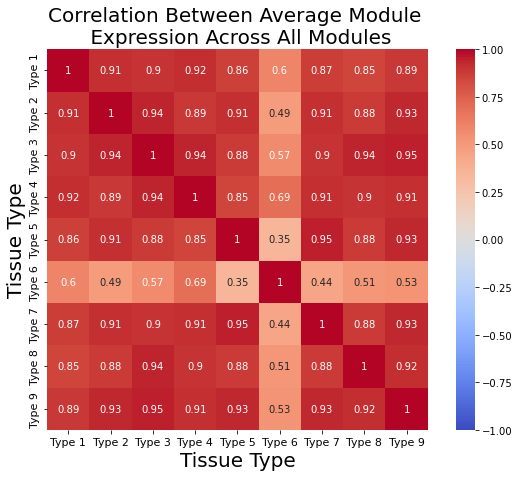

In [219]:
fig, ax = plt.subplots(figsize = (10,7))
fig.patch.set_facecolor('white')
ax = sns.heatmap(corr_of_modules_averaged_across_datasets.round(2), center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm',annot= True, square = True)
plt.ylabel("Tissue Type", fontsize = 20)
plt.xlabel("Tissue Type", fontsize = 20)

#sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Correlation Between Average Module \n Expression Across All Modules", fontsize = 20)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

In [220]:
high_mod_modules = slimmed_to_original_with_differnce_in_columns.loc[slimmed_to_original_with_differnce_in_columns['Gain In Modularity in Single Cell']>0.05].index.to_list()

In [221]:
len(high_mod_modules)

308

In [222]:
slimmed_to_high_mod_corr_results = module_avgd_across_datasets.loc[high_mod_modules].corr(method = 'spearman')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Type 1'),
  Text(0, 1.5, 'Type 2'),
  Text(0, 2.5, 'Type 3'),
  Text(0, 3.5, 'Type 4'),
  Text(0, 4.5, 'Type 5'),
  Text(0, 5.5, 'Type 6'),
  Text(0, 6.5, 'Type 7'),
  Text(0, 7.5, 'Type 8'),
  Text(0, 8.5, 'Type 9')])

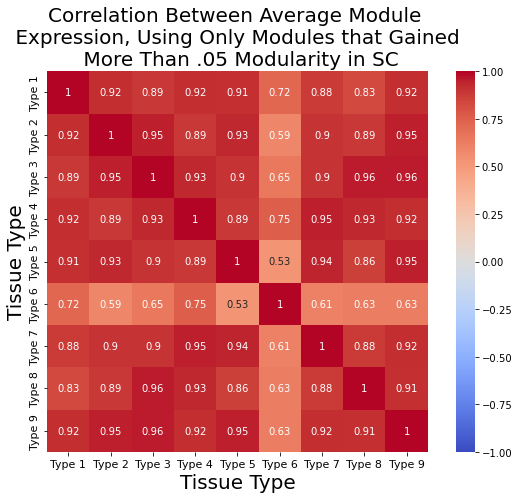

In [223]:
fig, ax = plt.subplots(figsize = (10,7))
fig.patch.set_facecolor('white')
ax = sns.heatmap(slimmed_to_high_mod_corr_results.round(2), center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm',annot= True, square = True)
plt.ylabel("Tissue Type", fontsize = 20)
plt.xlabel("Tissue Type", fontsize = 20)

#sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Correlation Between Average Module \n Expression, Using Only Modules that Gained \n More Than .05 Modularity in SC", fontsize = 20)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

In [224]:
test_add_code = 1


(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

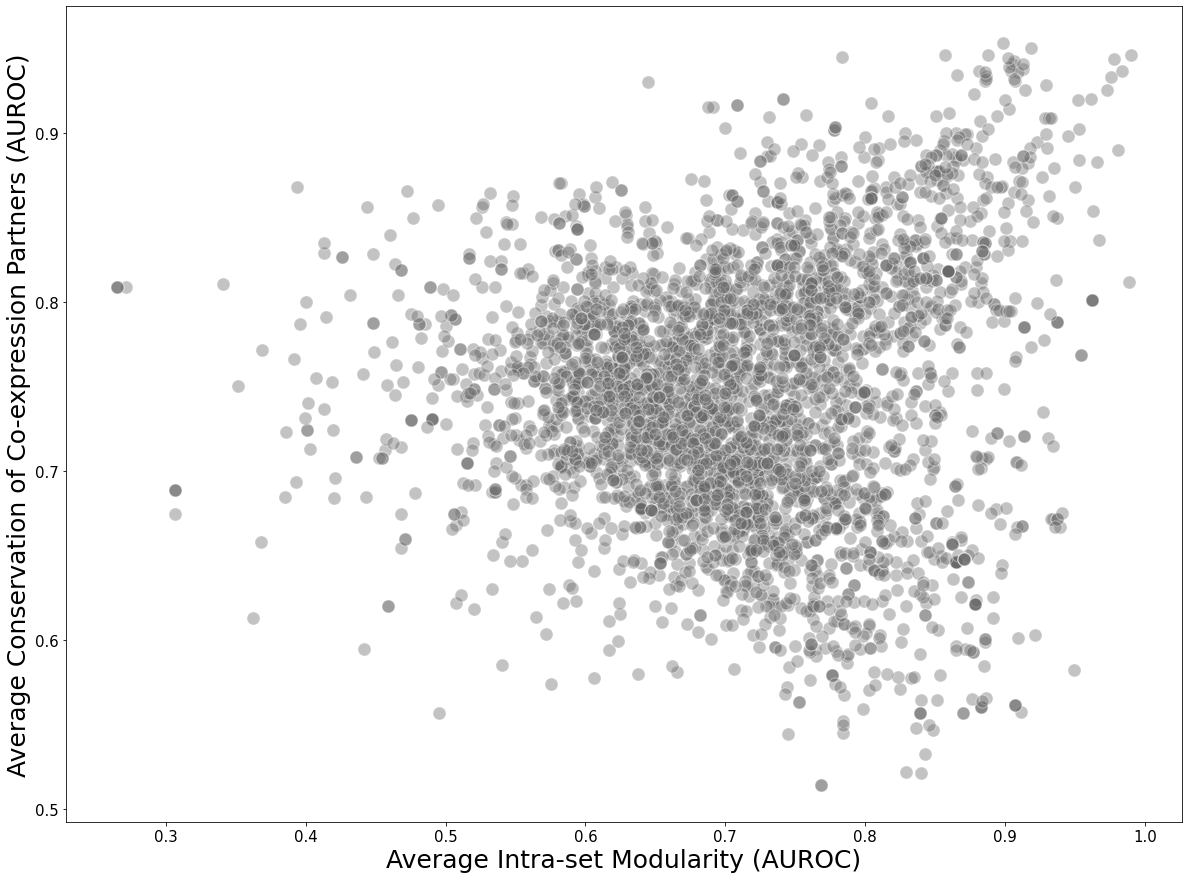

In [225]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = arabidopsis_all_group_data,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [226]:
arabidopsis_cococonet = CococoNet_reader.read_cococonet('arabidopsis')
arabidopsis_cococonet

AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
AT1G01020   1.000000   0.676041   0.885107   0.916603   0.167027   0.625596   
AT1G01030   0.676041   1.000000   0.707718   0.515532   0.420354   0.292083   
AT1G01040   0.885107   0.707718   1.000000   0.836387   0.545101   0.701558   
AT1G01050   0.916603   0.515532   0.836387   1.000000   0.562112   0.726964   
AT1G01060   0.167027   0.420354   0.545101   0.562112   1.000000   0.327202   
...              ...        ...        ...        ...        ...        ...   
ATCG01120   0.287853   0.270118   0.186425   0.213062   0.125488   0.083681   
ATCG01130   0.559907   0.463394   0.219380   0.412583   0.212731   0.077222   
ATCG01180   0.017205   0.083490   0.032348   0.046082   0.061676   0.022381   
ATCG01210   0.011806   0.059014   0.018332   0.029016   0.057518   0.026014   
ATCG01310   0.091015   0.108780   0.057761   0.086736   0.044208   0.028005   

           AT1G01080  AT1G01090  AT1G01100  AT1G01110  ...  ATCG01070  \
AT1G01020   0.801175   0.866369   0.954286   0.715750  ...   0.111731   
AT1G01030   0.687003   0.626281   0.483536   0.570675  ...   0.245167   
AT1G01040   0.656258   0.857046   0.657204   0.650843  ...   0.155183   
AT1G01050   0.837948   0.928252   0.952045   0.640223  ...   0.089440   
AT1G01060   0.242215   0.304953   0.217415   0.077569  ...   0.082518   
...              ...        ...        ...        ...  ...        ...   
ATCG01120   0.364707   0.333718   0.237716   0.149145  ...   0.858389   
ATCG01130   0.625678   0.496059   0.428496   0.226147  ...   0.881835   
ATCG01180   0.090228   0.069825   0.028903   0.015799  ...   0.751869   
ATCG01210   0.062831   0.043944   0.015468   0.018706  ...   0.687306   
ATCG01310   0.205339   0.176358   0.066842   0.050985  ...   0.410096   

           ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  ATCG01130  \
AT1G01020   0.193853   0.261697   0.299060   0.321617   0.287853   0.559907   
AT1G01030   0.215414   0.255414   0.306986   0.308402   0.270118   0.463394   
AT1G01040   0.230038   0.149740   0.334558   0.287951   0.186425   0.219380   
AT1G01050   0.177388   0.164935   0.236661   0.251851   0.213062   0.412583   
AT1G01060   0.125455   0.103488   0.187982   0.195059   0.125488   0.212731   
...              ...        ...        ...        ...        ...        ...   
ATCG01120   0.905572   0.926062   0.941864   0.954421   1.000000   0.969018   
ATCG01130   0.936241   0.946935   0.958553   0.960399   0.969018   1.000000   
ATCG01180   0.781811   0.740045   0.745181   0.676666   0.450607   0.467233   
ATCG01210   0.710940   0.676507   0.687223   0.567304   0.357960   0.412343   
ATCG01310   0.466130   0.465530   0.496910   0.453522   0.410586   0.483002   

           ATCG01180  ATCG01210  ATCG01310  
AT1G01020   0.017205   0.011806   0.091015  
AT1G01030   0.083490   0.059014   0.108780  
AT1G01040   0.032348   0.018332   0.057761  
AT1G01050   0.046082   0.029016   0.086736  
AT1G01060   0.061676   0.057518   0.044208  
...              ...        ...        ...  
ATCG01120   0.450607   0.357960   0.410586  
ATCG01130   0.467233   0.412343   0.483002  
ATCG01180   1.000000   0.999090   0.579657  
ATCG01210   0.999090   1.000000   0.511263  
ATCG01310   0.579657   0.511263   1.000000  

[20879 rows x 20879 columns]

In [227]:
arab_node_degree = arabidopsis_cococonet.sum().to_frame(name = 'Node Degree')

In [228]:
arab_node_degree

Node Degree
AT1G01020  13862.908480
AT1G01030   8594.077899
AT1G01040  13650.324223
AT1G01050  14595.784751
AT1G01060   4188.136623
...                 ...
ATCG01120   2921.902724
ATCG01130   4842.955751
ATCG01180    793.738176
ATCG01210    617.860635
ATCG01310   1352.797037

[20879 rows x 1 columns]

In [229]:
# for species in coconet_eudicots:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#         all_go_terms.loc[current_go_term,species] = mean_across_species

In [230]:
arabidopsis_annotations = get_go_annotations_as_panda('arabidopsis')

In [231]:
list_of_avg_go_term_node_degree = []
for current_go_term in arabidopsis_all_group_data.index.to_list():
    genes_in_go_term = arabidopsis_annotations.loc[arabidopsis_annotations[current_go_term] == 1].index.to_list() 
    node_degree_list = arab_node_degree[arab_node_degree.index.isin(genes_in_go_term)]
    avg_value = node_degree_list.mean().item()
    list_of_avg_go_term_node_degree.append(avg_value)




In [232]:
len(list_of_avg_go_term_node_degree)

3762

In [233]:
arabidopsis_all_group_data['Avg Node Degree'] = list_of_avg_go_term_node_degree

/tmp/ipykernel_2793519/2476857257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabidopsis_all_group_data['Avg Node Degree'] = list_of_avg_go_term_node_degree


In [234]:
arabidopsis_all_group_data

Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051194  0.815936  0.739692                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group  Avg Node Degree  
GO:0000003           0.585704     11257.365795  
GO:0000018           0.773632     12546.498098  
GO:0000027           0.823763     12478.698607  
GO:0000028           0.742855     12511.809062  
GO:0000030           0.696564     11629.236875  
...                       ...              ...  
GO:0051193           0.604822     10745.434697  
GO:0051184           0.575330     11252.581132  
GO:0051194           0.648557      9497.925910  
GO:0051182           0.595758     12330.467895  
GO:0051185           0.589837     12139.496063  

[3762 rows x 5 columns]

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

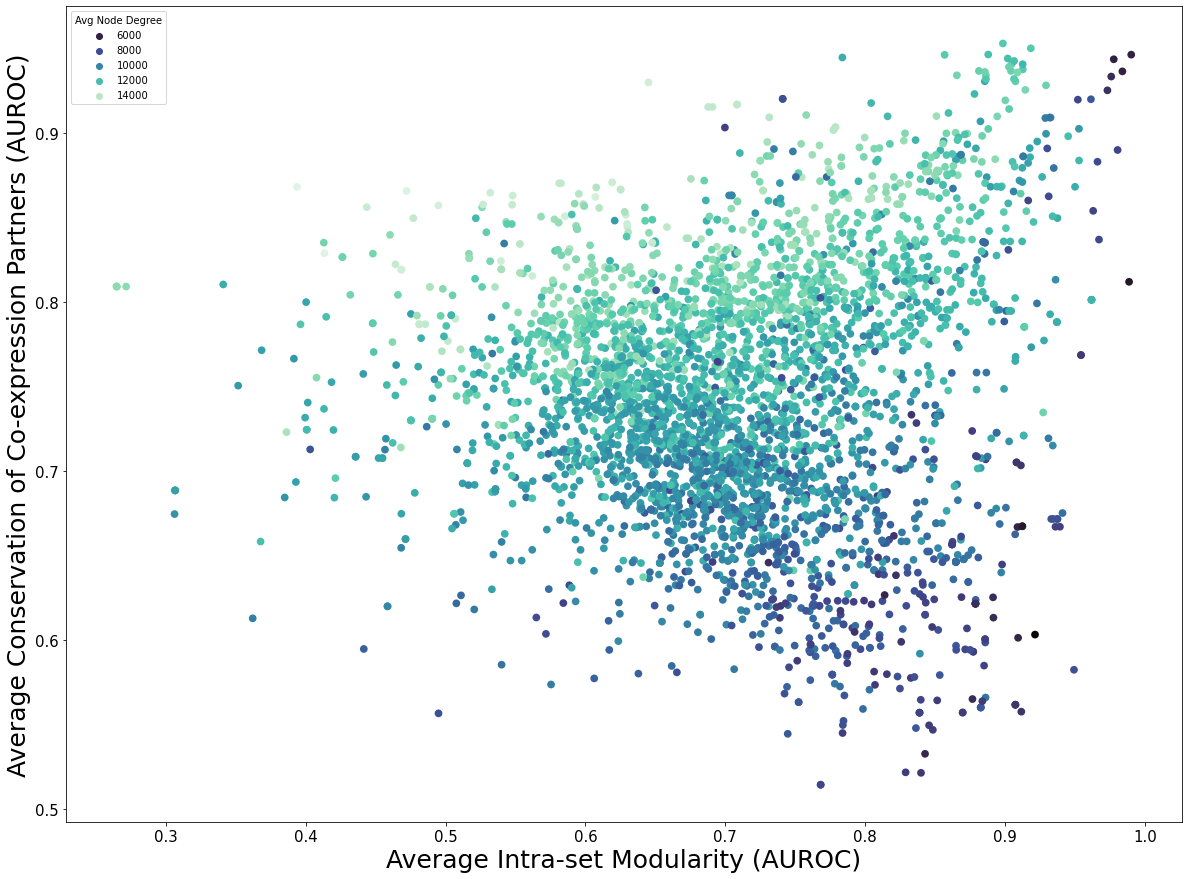

In [235]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = arabidopsis_all_group_data,y = 'Avg FC',x = 'Avg EGAD',s = 60,hue = "Avg Node Degree",edgecolor = 'none', palette = 'mako')

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [236]:
arab_genes_to_pandas

GO_term     GO:0000002  GO:0000003  GO:0000009  GO:0000012  GO:0000014  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         1.0         0.0         0.0         0.0   
AT1G01040          0.0         1.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:0000015  GO:0000018  GO:0000019  GO:0000023  GO:0000024  ...  \
NetworkIDs                                                              ...   
AT1G01010          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01020          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01030          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01040          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01046          0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01360          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01370          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01400          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01410          0.0         0.0         0.0         0.0         0.0  ...   

GO_term     GO:2001251  GO:2001252  GO:2001253  GO:2001257  GO:2001279  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         0.0         0.0         0.0         0.0   
AT1G01040          0.0         0.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:2001280  GO:2001289  GO:2001293  GO:2001294  GO:2001295  
NetworkIDs                                                              
AT1G01010          0.0         0.0         0.0         0.0         0.0  
AT1G01020          0.0         0.0         0.0         0.0         0.0  
AT1G01030          0.0         0.0         0.0         0.0         0.0  
AT1G01040          0.0         0.0         0.0         0.0         0.0  
AT1G01046          0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
ATMG01350          0.0         0.0         0.0         0.0         0.0  
ATMG01360          0.0         0.0         0.0         0.0         0.0  
ATMG01370          0.0         0.0         0.0         0.0         0.0  
ATMG01400          0.0         0.0         0.0         0.0         0.0  
ATMG01410          0.0         0.0         0.0         0.0         0.0  

[28874 rows x 10704 columns]

In [237]:
list_of_tau_values = pd.read_csv('/home/passala/Gene_duplication_project/R_data_files/tau_values_arabidopsis_genes.csv',index_col=0)
tau_means = list_of_tau_values.mean(axis =1)
tau_means = pd.DataFrame(data = tau_means, columns = ["Mean Tau Score From 4 Datasets"])
tau_means

Mean Tau Score From 4 Datasets
Gene                                     
AT1G01010                        0.638989
AT1G01020                        0.530322
AT1G01030                        0.868478
AT1G01040                        0.643144
AT1G01050                        0.456970
...                                   ...
ATCG01110                        0.828732
ATCG01120                        0.708998
ATCG01130                        0.627930
ATCG01230                        0.997982
ATCG01310                        0.884492

[22271 rows x 1 columns]

In [238]:
slimmed_pandas = arab_genes_to_pandas.loc[arab_genes_to_pandas.index.isin(tau_means.index)]

In [239]:
slimmed_pandas

GO_term     GO:0000002  GO:0000003  GO:0000009  GO:0000012  GO:0000014  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         1.0         0.0         0.0         0.0   
AT1G01040          0.0         1.0         0.0         0.0         0.0   
AT1G01050          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01275          0.0         0.0         0.0         0.0         0.0   
ATMG01330          0.0         0.0         0.0         0.0         0.0   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:0000015  GO:0000018  GO:0000019  GO:0000023  GO:0000024  ...  \
NetworkIDs                                                              ...   
AT1G01010          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01020          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01030          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01040          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01050          0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
ATMG01275          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01330          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01360          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01370          0.0         0.0         0.0         0.0         0.0  ...   

GO_term     GO:2001251  GO:2001252  GO:2001253  GO:2001257  GO:2001279  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         0.0         0.0         0.0         0.0   
AT1G01040          0.0         0.0         0.0         0.0         0.0   
AT1G01050          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01275          0.0         0.0         0.0         0.0         0.0   
ATMG01330          0.0         0.0         0.0         0.0         0.0   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:2001280  GO:2001289  GO:2001293  GO:2001294  GO:2001295  
NetworkIDs                                                              
AT1G01010          0.0         0.0         0.0         0.0         0.0  
AT1G01020          0.0         0.0         0.0         0.0         0.0  
AT1G01030          0.0         0.0         0.0         0.0         0.0  
AT1G01040          0.0         0.0         0.0         0.0         0.0  
AT1G01050          0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
ATMG01275          0.0         0.0         0.0         0.0         0.0  
ATMG01330          0.0         0.0         0.0         0.0         0.0  
ATMG01350          0.0         0.0         0.0         0.0         0.0  
ATMG01360          0.0         0.0         0.0         0.0         0.0  
ATMG01370          0.0         0.0         0.0         0.0         0.0  

[22270 rows x 10704 columns]

In [240]:

arabidopsis_all_group_data





Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051194  0.815936  0.739692                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group  Avg Node Degree  
GO:0000003           0.585704     11257.365795  
GO:0000018           0.773632     12546.498098  
GO:0000027           0.823763     12478.698607  
GO:0000028           0.742855     12511.809062  
GO:0000030           0.696564     11629.236875  
...                       ...              ...  
GO:0051193           0.604822     10745.434697  
GO:0051184           0.575330     11252.581132  
GO:0051194           0.648557      9497.925910  
GO:0051182           0.595758     12330.467895  
GO:0051185           0.589837     12139.496063  

[3762 rows x 5 columns]

In [241]:
column_of_average_tau = []
for go_group in arabidopsis_all_group_data.iterrows():
    current_go_group = go_group[0]
    genes_for_go_group = slimmed_pandas.loc[slimmed_pandas[current_go_group] == 1].index.to_list()
    current_tau_means = tau_means.loc[genes_for_go_group].mean().item()
    column_of_average_tau.append(current_tau_means)
    

In [242]:
len(column_of_average_tau)

3762

In [243]:
arabidopsis_all_group_data['Module Avg Tau Score'] = column_of_average_tau
arabidopsis_all_group_data

/tmp/ipykernel_2793519/85272409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabidopsis_all_group_data['Module Avg Tau Score'] = column_of_average_tau


Avg FC  Avg EGAD                              Name  \
GO:0000003  0.752135  0.637415                      reproduction   
GO:0000018  0.760489  0.718649   regulation of DNA recombination   
GO:0000027  0.937799  0.912810  ribosomal large subunit assembly   
GO:0000028  0.946437  0.856894  ribosomal small subunit assembly   
GO:0000030  0.716687  0.688263      mannosyltransferase activity   
...              ...       ...                               ...   
GO:0051193  0.769318  0.656521                               NaN   
GO:0051184  0.752668  0.418488                               NaN   
GO:0051194  0.815936  0.739692                               NaN   
GO:0051182  0.746270  0.517158                               NaN   
GO:0051185  0.751670  0.542371                               NaN   

            Single Cell Group  Avg Node Degree  Module Avg Tau Score  
GO:0000003           0.585704     11257.365795              0.711130  
GO:0000018           0.773632     12546.498098              0.701484  
GO:0000027           0.823763     12478.698607              0.694440  
GO:0000028           0.742855     12511.809062              0.689520  
GO:0000030           0.696564     11629.236875              0.683473  
...                       ...              ...                   ...  
GO:0051193           0.604822     10745.434697              0.665803  
GO:0051184           0.575330     11252.581132              0.648836  
GO:0051194           0.648557      9497.925910              0.776887  
GO:0051182           0.595758     12330.467895              0.625815  
GO:0051185           0.589837     12139.496063              0.642418  

[3762 rows x 6 columns]

In [244]:
tau_means.loc[genes_for_go_group].mean().item()

0.6424179425061551

(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

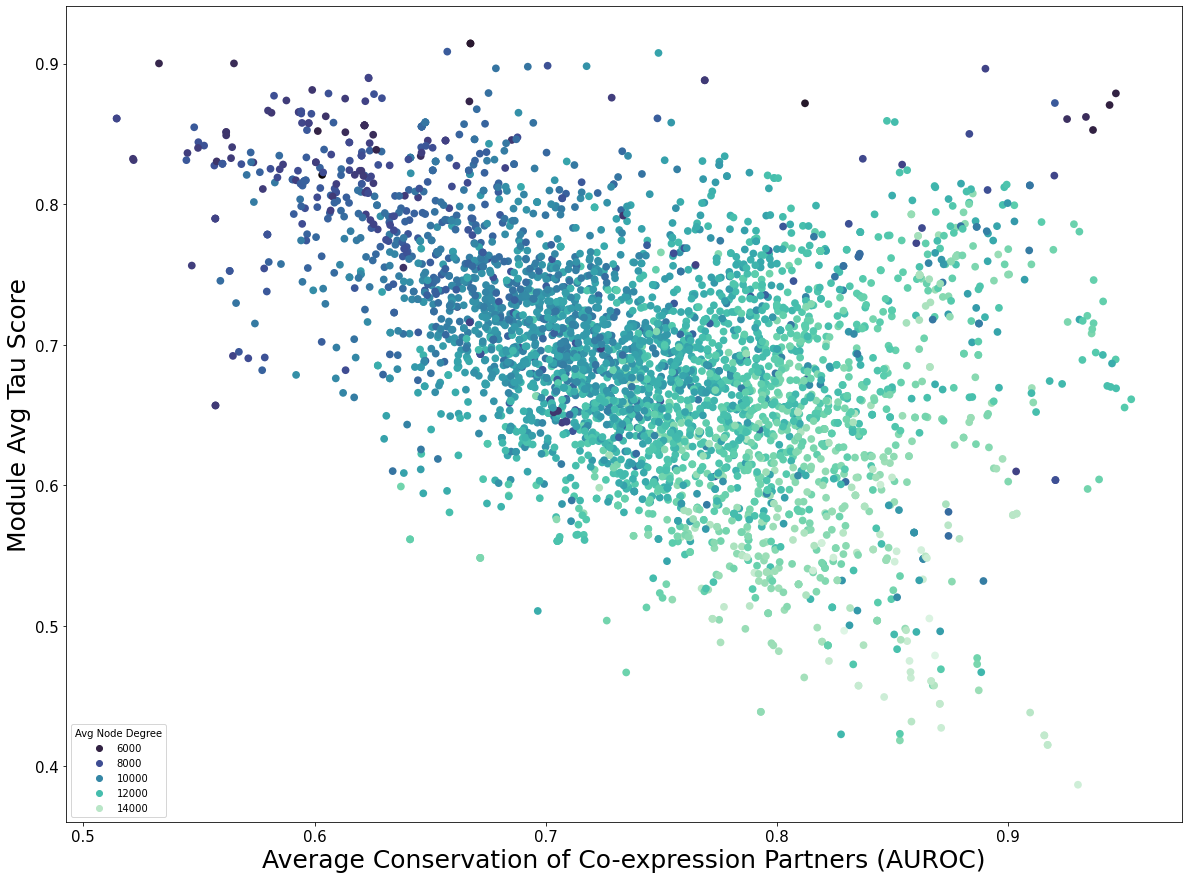

In [245]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = arabidopsis_all_group_data,y = 'Module Avg Tau Score',x = 'Avg FC',s = 60,hue = "Avg Node Degree",edgecolor = 'none', palette = 'mako')

plt.ylabel("Module Avg Tau Score", fontsize = 25)
plt.xlabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [247]:
slimmed_to_original_list_with_tau = slimmed_to_original_list.merge(arabidopsis_all_group_data[['Module Avg Tau Score']],right_index= True, left_index = True, how = 'left')

In [248]:
slimmed_to_original_list_with_tau.loc[slimmed_to_original_list_with_tau['Module Avg Tau Score'] == np.nan]

Empty DataFrame
Columns: [Avg FC, Avg EGAD, Name, Single Cell Group, Annotation, Module Avg Tau Score]
Index: []

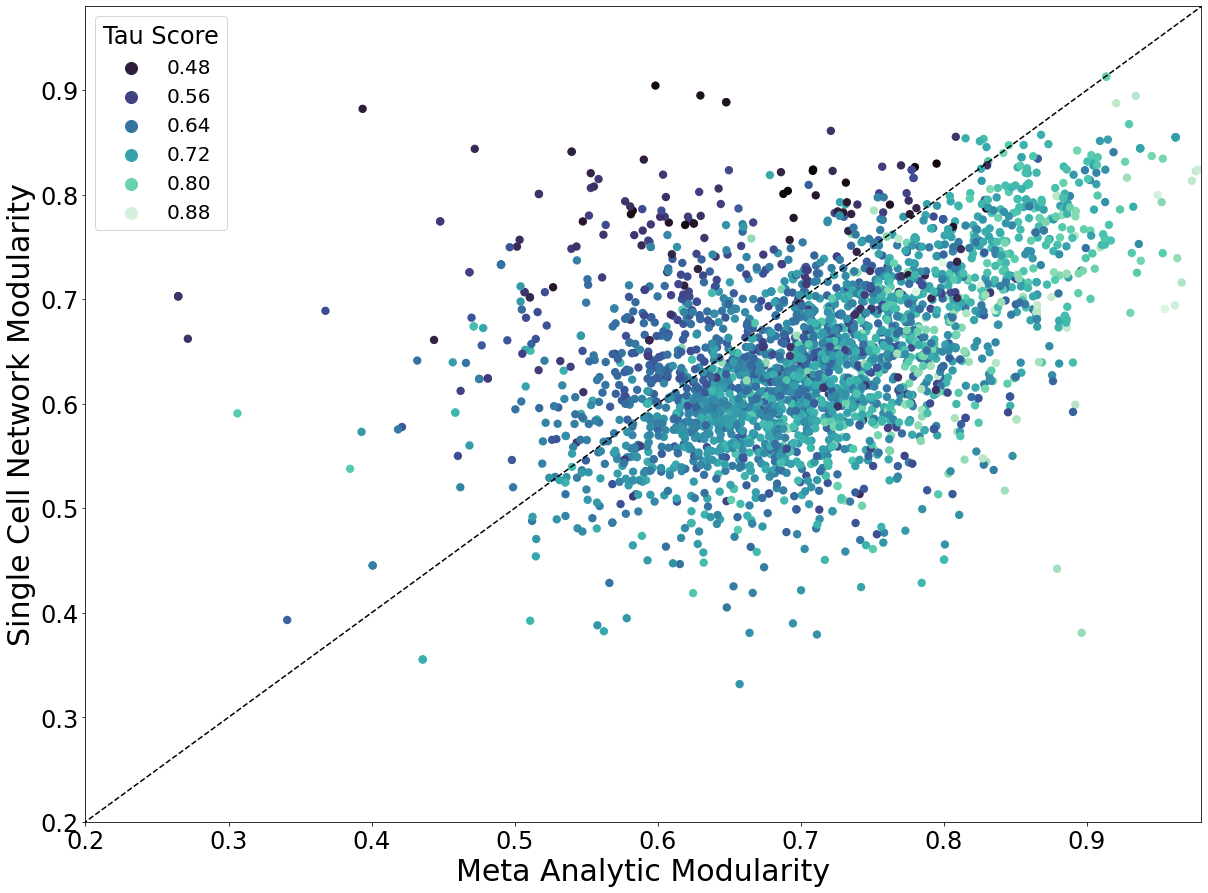

In [257]:
fig, ax = plt.subplots(figsize = (20,15))
fig.patch.set_facecolor('white')
sns.scatterplot(data = slimmed_to_original_list_with_tau,y = 'Single Cell Group',x = 'Avg EGAD',s = 70,hue = 'Module Avg Tau Score', edgecolor = 'none', palette = 'mako')
plt.plot(ident_line,ident_line,'--k')
plt.xlim(.2,.98)
plt.ylim(.2,.98)
plt.ylabel("Single Cell Network Modularity", fontsize = 30)
plt.xlabel("Meta Analytic Modularity", fontsize = 30)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(fontsize= 20,markerscale = 2, title = 'Tau Score', title_fontsize = 24)

#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

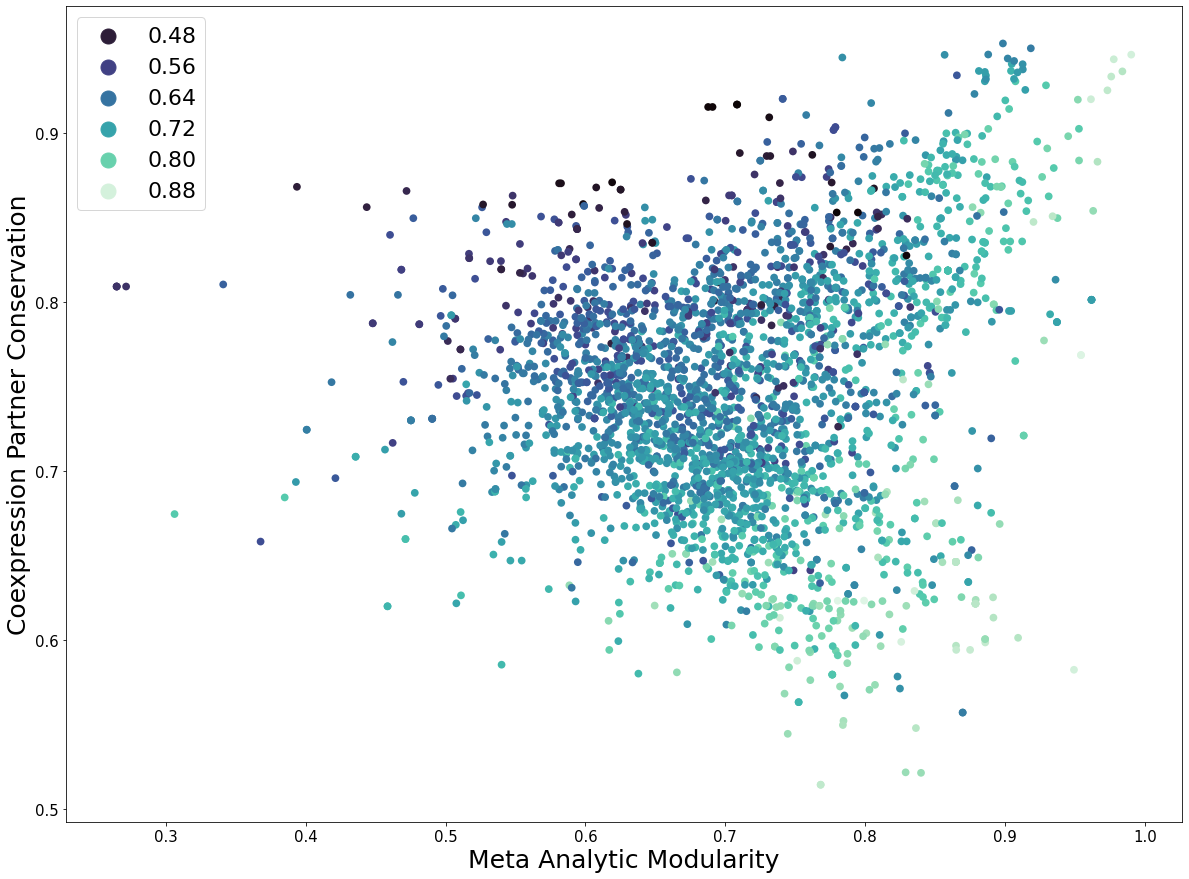

In [250]:
fig, ax = plt.subplots(figsize = (20,15))
fig.patch.set_facecolor('white')
sns.scatterplot(data = slimmed_to_original_list_with_tau,y = 'Avg FC',x = 'Avg EGAD',s = 60,hue = 'Module Avg Tau Score', edgecolor = 'none', palette = 'mako')
#plt.plot(ident_line,ident_line,'--k')
# plt.xlim(.2,.98)
# plt.ylim(.2,.98)
plt.ylabel("Coexpression Partner Conservation", fontsize = 25)
plt.xlabel("Meta Analytic Modularity", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)